# 📌  Image Segmentation

## What is Segmentation?

Segmentation means **dividing an image into meaningful parts**.

* In **fMRI or anatomical MRI**, the task is usually to separate:

  * **Brain tissue** from background air
  * **Gray matter, white matter, cerebrospinal fluid (CSF/ventricles)**
  * Or sometimes specific **regions of interest (ROIs)**
* The purpose is to analyze only the relevant voxels and exclude irrelevant or noisy ones.

---

## Why is Segmentation Important in fMRI?

1. **Efficiency** – Background voxels (air) don’t carry useful signals.
2. **Accuracy** – Skull and skin have very different intensity than brain tissue, and can bias statistics.
3. **Specificity** – Sometimes we want to analyze only GM (where neuronal activity is localized), not WM or CSF.

Without segmentation, you risk averaging over mixed signals or wasting computation on irrelevant regions.

---

## Example Setup

We start with a **3D fMRI BOLD volume** and look at one slice:

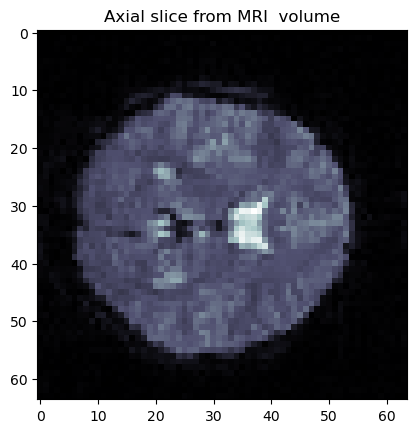

(64, 64, 25)
(64, 64)


In [2]:
from ndslib import load_data
import matplotlib.pyplot as plt

brain = load_data("bold_volume")   # 3D brain volume
slice10 = brain[:, :, 10]          # take one axial slice

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
ax.set_title("Axial slice from MRI  volume")
plt.show()
print(brain.shape)
print(slice10.shape)



➡️ In this slice:

* **Background air** → black regions around the head
* **Skull and skin** → very bright thin outlines
* **Ventricles (CSF)** → bright blobs inside brain
* **Brain tissue** → mid-intensity region we care about

---

## Different Segmentation Approaches

We’ll gradually build intuition for multiple methods:

1. **Thresholding**

   * Simple cutoff on intensity.
   * Works for removing background (air vs. tissue).
   * Struggles with separating skull vs. brain or GM vs. WM.

2. **Region-based methods**

   * Start from seed points and grow regions based on similarity.
   * Can capture smooth structures, but sensitive to noise.

3. **Edge-based methods**

   * Use gradient filters (like Sobel) to find tissue boundaries.
   * Often combined with other methods.

4. **Advanced methods (later chapters)**

   * Morphological approaches (erosion/dilation-based cleanups).
   * Clustering (e.g., k-means, GMM).
   * Machine learning (CNNs for segmentation).

---

# 📌 1 Intensity-Based Segmentation

## Concept

The simplest way to separate brain from non-brain voxels is to use their **intensity distribution**.

* **Background (air)** → dark pixels (low intensity, near 0).
* **Brain tissue & skull** → brighter pixels (higher intensity).

We can use the **image histogram** to see these groups and choose a **threshold** to separate them.

---

## Step 1: Histogram of Intensities

A histogram lets us see how many voxels fall into each intensity range.

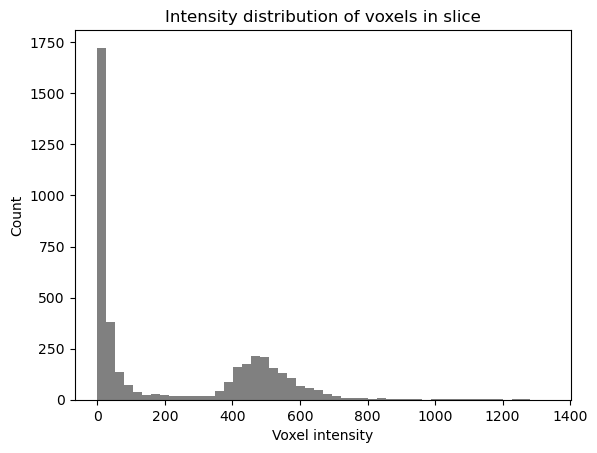

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ndslib import load_data

# Plot histogram
fig, ax = plt.subplots()
ax.hist(slice10.flat, bins=50, color="gray")
ax.set_title("Intensity distribution of voxels in slice")
ax.set_xlabel("Voxel intensity")
ax.set_ylabel("Count")
plt.show()



👉 You should see **two peaks**:

* Left peak (near 0) = background.
* Right peak (higher values) = brain + skull + ventricles.

---

## Step 2: Thresholding

A simple segmentation rule:

$$
\text{mask}(i,j) = 
\begin{cases}
1 & \text{if } I(i,j) > T \\
0 & \text{otherwise}
\end{cases}
$$

We start with the **mean intensity** as the threshold.

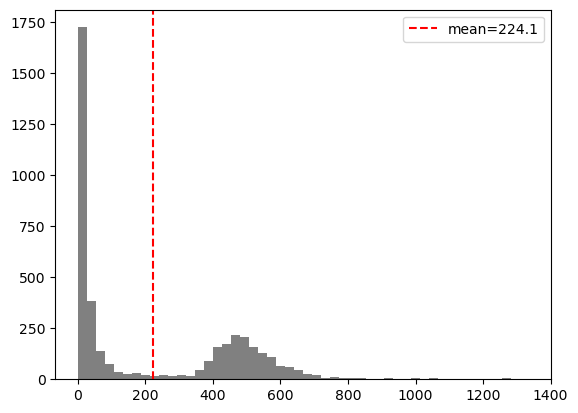

In [ ]:
mean_val = np.mean(slice10)

fig, ax = plt.subplots()
ax.hist(slice10.flat, bins=50, color="gray")
ax.axvline(mean_val, linestyle='dashed', color='red', label=f"mean={mean_val:.1f}")
ax.legend()
plt.show()

## Step 3: Create Segmentation Mask

Using **Boolean indexing**, we keep voxels above the threshold.

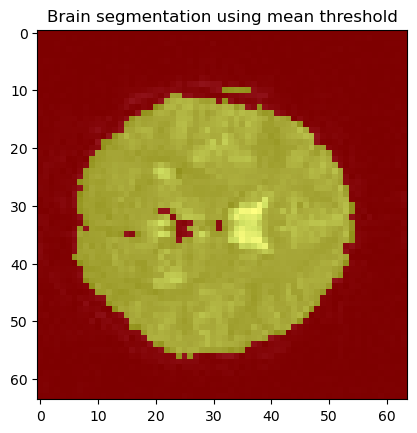

In [ ]:
segmentation = np.zeros_like(slice10)
segmentation[slice10 > mean_val] = 1

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
ax.imshow(segmentation, alpha=0.5, cmap="autumn")  # overlay in orange
ax.set_title("Brain segmentation using mean threshold")
plt.show()


Now you’ll see:

* The mask (orange) captures most of the brain.
* But **skull and ventricles are incorrectly included**, since they are bright.

---

## Limitations

* **Too crude**: a single threshold can’t distinguish between skull, ventricles, and brain.
* **Intensity overlap**: different tissues can have similar brightness.
* **Sensitivity**: noise and scanner variability shift the histogram.

---

## Implications in fMRI

* **Pros**: Quick and effective for removing air/background voxels.
* **Cons**: Misclassifies CSF and skull → not reliable for fine anatomical separation.
* Often used as a **first preprocessing step** (before more sophisticated methods like morphological cleaning or atlas-based segmentation).

---

# 1.1 Otsu’s Method

## Intuition

Otsu’s method (1979) is a **classical thresholding technique** that automatically finds the “best” threshold.

* Goal: **separate foreground and background** so that each group is as **internally consistent** (low variance) as possible.
* Equivalent to **minimizing intra-class variance** (variance within each group).
* Or, equivalently, **maximizing inter-class variance** (difference between groups).

---

## Step 1: Manual Implementation

We loop through every candidate threshold and compute intra-class variance:

In [ ]:
import numpy as np

min_intraclass_variance = np.inf
threshold = None

for candidate in np.unique(slice10):
    background = slice10[slice10 < candidate]
    foreground = slice10[slice10 >= candidate]

    if len(foreground) and len(background):
        bg_var = np.var(background) * len(background)
        fg_var = np.var(foreground) * len(foreground)
        intraclass_var = bg_var + fg_var

        if intraclass_var < min_intraclass_variance:
            min_intraclass_variance = intraclass_var
            threshold = candidate

print("Otsu threshold:", threshold)

Otsu threshold: 274.0


## Step 2: Compare with Mean Threshold

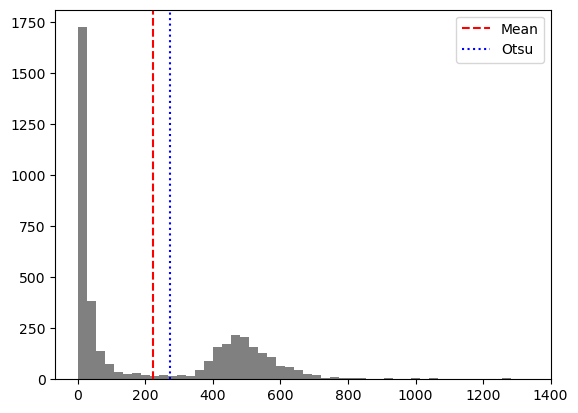

In [ ]:
import matplotlib.pyplot as plt

mean_val = np.mean(slice10)

fig, ax = plt.subplots()
ax.hist(slice10.flat, bins=50, color="gray")
ax.axvline(mean_val, linestyle='dashed', color="red", label="Mean")
ax.axvline(threshold, linestyle='dotted', color="blue", label="Otsu")
ax.legend()
plt.show()


* **Dashed line (mean)** = crude threshold.
* **Dotted line (Otsu)** = smarter, usually slightly higher, giving better separation.

---

## Step 3: Apply Mask

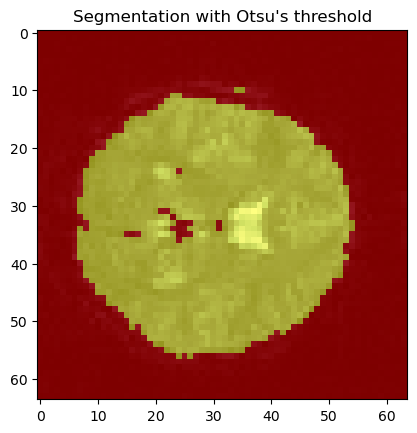

In [ ]:
segmentation = np.zeros_like(slice10)
segmentation[slice10 > threshold] = 1

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
ax.imshow(segmentation, alpha=0.5, cmap="autumn")
ax.set_title("Segmentation with Otsu's threshold")
plt.show()


✅ Works very well for separating brain vs. air, but **still misclassifies ventricles** (CSF) as brain tissue.

---

## Step 4: Scikit-Image Otsu (much faster)

In [ ]:
from skimage.filters import threshold_otsu

otsu_val = threshold_otsu(slice10)
print("Scikit-image Otsu:", otsu_val)

Scikit-image Otsu: 268.564453125



This is vectorized and optimized, so use it in practice.

---

# 1.2 Multi-Otsu Thresholding

## Motivation

* A **single threshold** isn’t enough when you want to separate **more than two regions**.
* In brain MRI, we often want:

  * **Background/air** (dark)
  * **Brain tissue** (mid-range)
  * **CSF or skull** (bright)

Multi-Otsu generalizes Otsu’s principle to **multiple thresholds**.

---

## Example with 3 Classes

Multi-Otsu thresholds: [252.91992188 623.17382812]


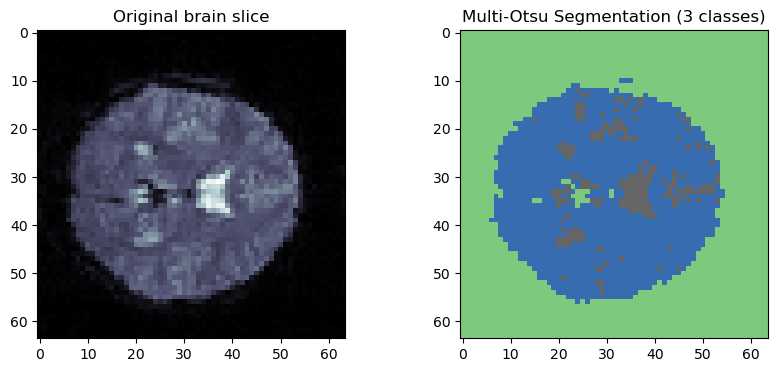

In [ ]:
from skimage.filters import threshold_multiotsu

# Find two thresholds for 3 classes
thresholds = threshold_multiotsu(slice10, classes=3)
print("Multi-Otsu thresholds:", thresholds)

# Segment into 3 regions
segmentation = np.digitize(slice10, bins=thresholds)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(slice10, cmap="bone")
ax[0].set_title("Original brain slice")
ax[1].imshow(segmentation, cmap="Accent")
ax[1].set_title("Multi-Otsu Segmentation (3 classes)")
plt.show()



## Interpretation

* `segmentation == 0` → background (air, very dark).
* `segmentation == 1` → brain tissue (mid-intensity).
* `segmentation == 2` → CSF/ventricles & skull (bright).

This **addresses the ventricles problem** better than single Otsu.

---

## Implications in Neuroimaging

* **Otsu**: Good for skull-stripping or background removal.
* **Multi-Otsu**: More powerful for **tissue classification** (e.g., separating CSF from brain).
* Still limited: intensity overlaps → more advanced methods (clustering, atlas priors, CNNs) are needed for precise neuroanatomical segmentation.


## compares **Mean vs Otsu vs Multi-Otsu** side-by-side, both on the **histogram** and as **overlay masks** on the slice.

Mean: 224.123
Otsu: 268.564
Multi-Otsu (3 classes): [252.91992188 623.17382812]


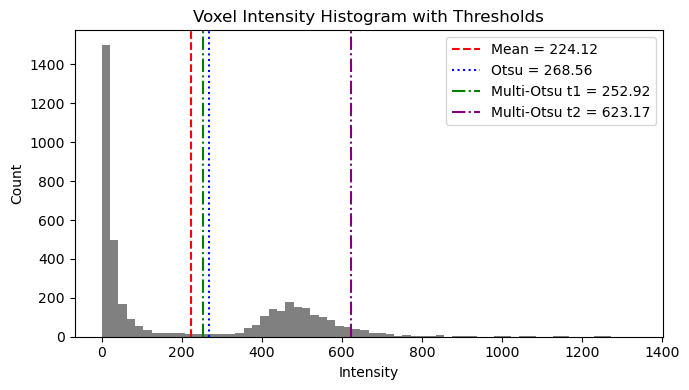

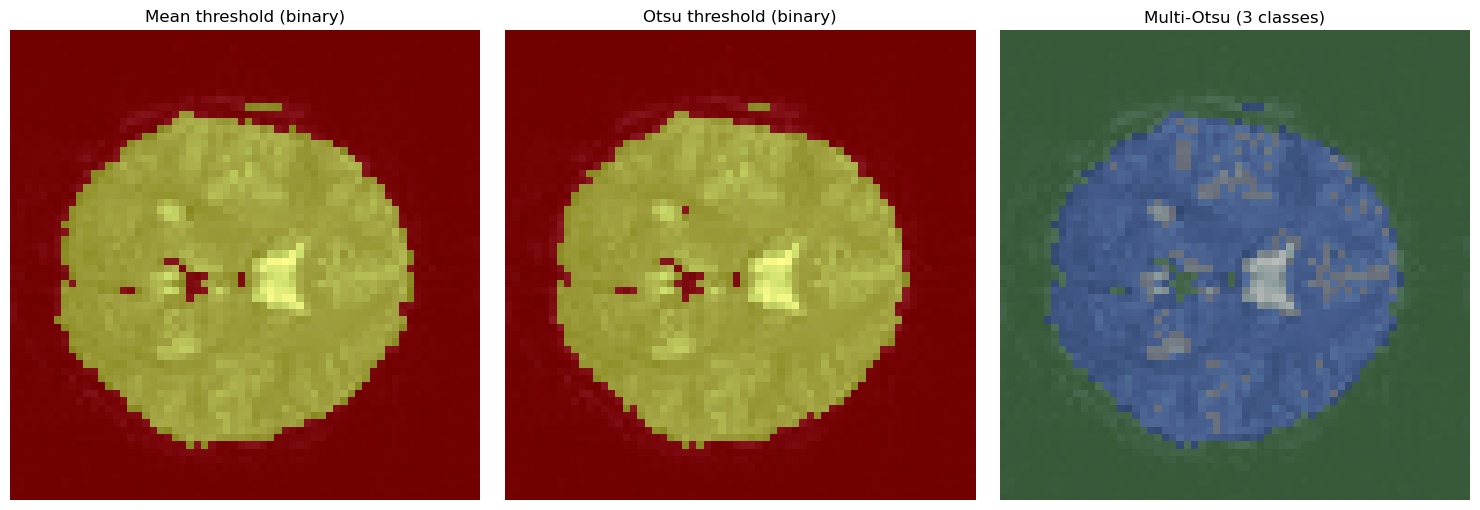

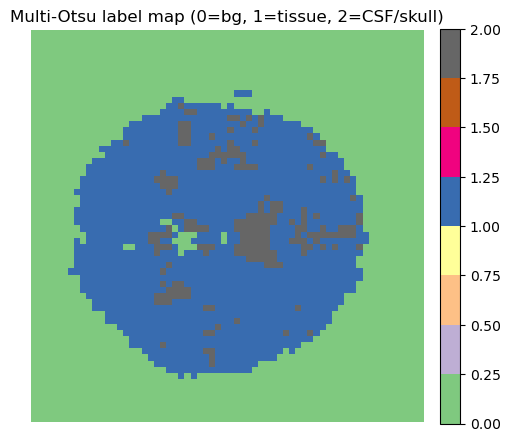

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_multiotsu

# --- thresholds ---
mean_val = float(np.mean(slice10))
otsu_val = float(threshold_otsu(slice10))
multi_vals = threshold_multiotsu(slice10, classes=3)   # 2 thresholds -> 3 classes

print(f"Mean: {mean_val:.3f}")
print(f"Otsu: {otsu_val:.3f}")
print(f"Multi-Otsu (3 classes): {multi_vals}")

# --- masks ---
mask_mean = (slice10 > mean_val).astype(np.uint8)  # binary (0/1)
mask_otsu = (slice10 > otsu_val).astype(np.uint8)  # binary (0/1)

# For multi-otsu: label map with values {0,1,2}
labels_multi = np.digitize(slice10, bins=multi_vals)

# --- figure 1: histogram with thresholds ---
fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.hist(slice10.ravel(), bins=64, color="gray")
ax.axvline(mean_val,  color="red",   linestyle="--",  label=f"Mean = {mean_val:.2f}")
ax.axvline(otsu_val,  color="blue",  linestyle=":",   label=f"Otsu = {otsu_val:.2f}")
ax.axvline(multi_vals[0], color="green", linestyle="-.", label=f"Multi-Otsu t1 = {multi_vals[0]:.2f}")
ax.axvline(multi_vals[1], color="purple",linestyle="-.", label=f"Multi-Otsu t2 = {multi_vals[1]:.2f}")
ax.set_title("Voxel Intensity Histogram with Thresholds")
ax.set_xlabel("Intensity"); ax.set_ylabel("Count")
ax.legend()
plt.tight_layout(); plt.show()

# --- figure 2: overlay masks on the slice ---
cmap_slice = "bone"

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(slice10, cmap=cmap_slice); axes[0].set_title("Mean threshold (binary)")
axes[0].imshow(mask_mean, alpha=0.45, cmap="autumn"); axes[0].axis("off")

axes[1].imshow(slice10, cmap=cmap_slice); axes[1].set_title("Otsu threshold (binary)")
axes[1].imshow(mask_otsu, alpha=0.45, cmap="autumn"); axes[1].axis("off")

# Multi-Otsu as 3-class label map (background / tissue / bright-CSF&skull)
axes[2].imshow(slice10, cmap=cmap_slice); axes[2].set_title("Multi-Otsu (3 classes)")
im2 = axes[2].imshow(labels_multi, alpha=0.45, cmap="Accent"); axes[2].axis("off")

plt.tight_layout(); plt.show()

# --- (optional) figure 3: plain label map for Multi-Otsu ---
fig, ax = plt.subplots(1,1, figsize=(5,5))
im = ax.imshow(labels_multi, cmap="Accent")
ax.set_title("Multi-Otsu label map (0=bg, 1=tissue, 2=CSF/skull)")
ax.axis("off")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()




### What to look for

* **Mean**: quick background removal, but includes ventricles & skull as “brain”.
* **Otsu**: better separation of air vs brain+skull; still merges ventricles with brain.
* **Multi-Otsu (3 classes)**: separates **background**, **brain tissue**, and **bright CSF/skull** into distinct labels — usually the most informative for this slice.



# 1.3 Comparing Threshold Methods with `try_all_threshold`

## What it does

`skimage.filters.try_all_threshold` runs a **panel of global thresholding methods** (Otsu, Yen, Li, Triangle, Isodata, Minimum, Mean, etc.) and shows:

* Each **threshold value** it computed, and
* The **binary mask** produced by applying that threshold.

It’s a quick way to **scan multiple approaches** and spot which one *looks* best for your image.

### Run it on your slice

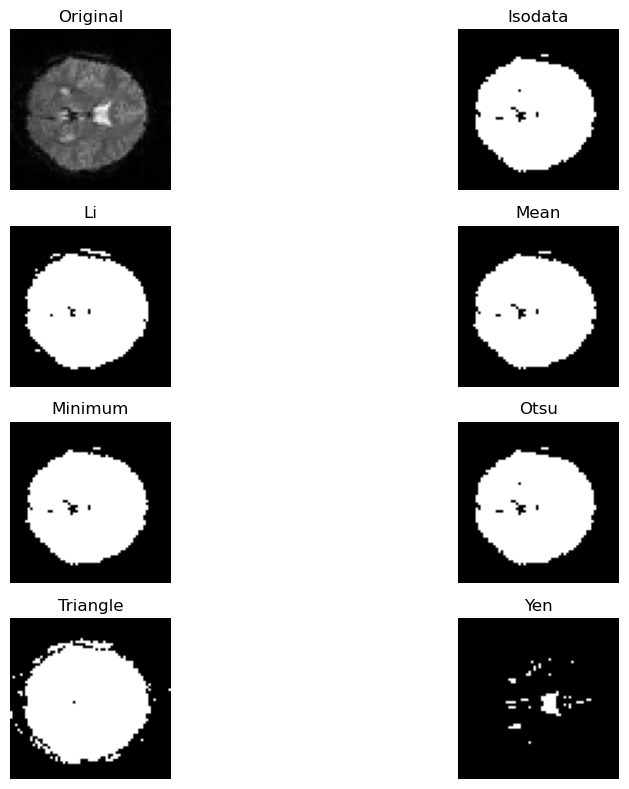

In [ ]:
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(slice10, figsize=(12, 8), verbose=False)
plt.show()


You’ll get a grid of masks; use it for a first-pass visual comparison.
But visual inspection is subjective—let’s also measure quality.

---


### Evaluation Against a Reference

**Gold standard (best practice):**
If you have a **reference/ground-truth mask** `gt_mask` (e.g., brain vs. non-brain labels manually drawn or from a trusted atlas), you can compute **Dice similarity** (a.k.a. F1 score for binary sets) to evaluate segmentation quality.

$$
\text{Dice}(A,B) = \frac{2|A \cap B|}{|A| + |B|}
$$

* $A$ = candidate segmentation mask
* $B$ = reference ground truth
* Dice = 1.0 → perfect overlap, Dice = 0.0 → no overlap

This is the **objective benchmark** for comparing methods.

---

**When no ground truth is available (our case):**

* You can create a **proxy mask** (e.g., Multi-Otsu’s middle class or Otsu + morphological cleanup).
* Then compute Dice scores for other methods relative to that proxy.
* This doesn’t give you an absolute “truth,” but it allows **relative comparison** (which methods align better with the chosen proxy).

---

### Why Dice?

* Balances **sensitivity** (how much brain you keep) and **specificity** (how much non-brain you avoid).
* Works well for **imbalanced problems** like brain segmentation, where background is much larger than foreground.
* Widely used in neuroimaging, especially for evaluating skull-stripping or tissue classification.

---

👉 In practice:

* Use **Dice with a true `gt_mask`** whenever possible.
* If no ground truth exists, use a **proxy mask** and/or **visual inspection** to judge which thresholding method behaves better.




minimum    Dice (vs proxy) = 0.9318
otsu       Dice (vs proxy) = 0.9299
isodata    Dice (vs proxy) = 0.9299
mean       Dice (vs proxy) = 0.9282
li         Dice (vs proxy) = 0.9091
triangle   Dice (vs proxy) = 0.8684
yen        Dice (vs proxy) = 0.0000


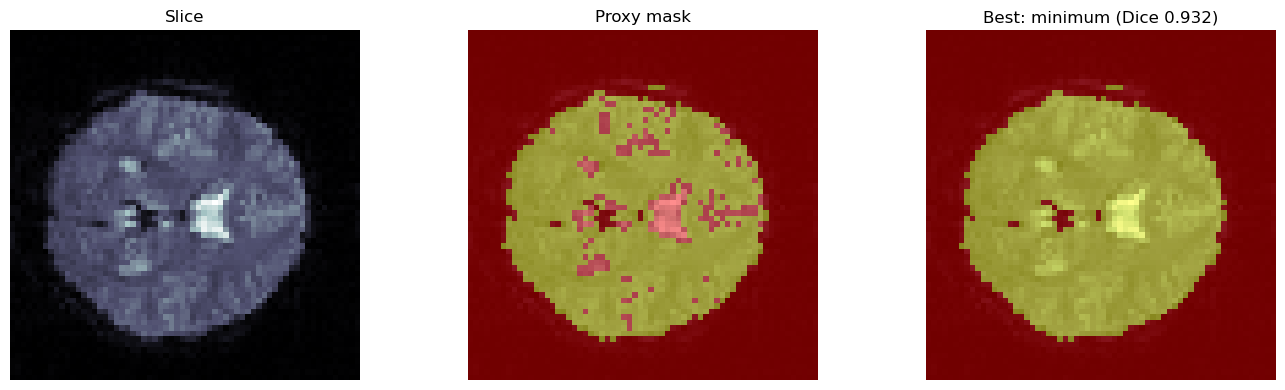

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import (
    threshold_otsu, threshold_yen, threshold_li,
    threshold_triangle, threshold_isodata, threshold_minimum,
    threshold_mean, threshold_multiotsu
)
from skimage.morphology import remove_small_objects, remove_small_holes

# ---- your slice assumed present ----
# slice10  # 2D numpy array

# ================================
# 1) Choose a PROXY mask (no GT)
# ================================
USE_MULTI_OTSU_PROXY = True  # set False to use morphology-cleaned Otsu proxy

if USE_MULTI_OTSU_PROXY:
    # Multi-Otsu -> 3 classes: [0]=bg (dark), [1]=tissue (mid), [2]=bright (CSF/skull)
    t1, t2 = threshold_multiotsu(slice10, classes=3)
    proxy_mask = ((slice10 > t1) & (slice10 <= t2)).astype(np.uint8)
else:
    # Otsu + light morphology cleanup as a rough brain-only proxy
    otsu_val = threshold_otsu(slice10)
    proxy_mask = (slice10 > otsu_val)
    proxy_mask = remove_small_objects(proxy_mask, 100)
    proxy_mask = remove_small_holes(proxy_mask, 100)
    proxy_mask = proxy_mask.astype(np.uint8)

# ================================
# 2) Candidate thresholds & masks
# ================================
th_funcs = {
    "mean":     threshold_mean,
    "otsu":     threshold_otsu,
    "yen":      threshold_yen,
    "li":       threshold_li,
    "triangle": threshold_triangle,
    "isodata":  threshold_isodata,
    "minimum":  threshold_minimum,
}

masks = {}
for name, fn in th_funcs.items():
    try:
        t = fn(slice10)
        masks[name] = (slice10 > t).astype(np.uint8)
    except Exception as e:
        print(f"[warn] {name} failed: {e}")

# ================================
# 3) Dice vs. proxy mask
# ================================
def dice(a, b):
    inter = np.logical_and(a==1, b==1).sum()
    return (2*inter) / (a.sum() + b.sum() + 1e-9)

scores = {name: dice(m, proxy_mask) for name, m in masks.items()}
for k, v in sorted(scores.items(), key=lambda kv: kv[1], reverse=True):
    print(f"{k:9s}  Dice (vs proxy) = {v:.4f}")

# ================================
# (Optional) quick visualization
# ================================
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].imshow(slice10, cmap="bone"); axes[0].set_title("Slice"); axes[0].axis("off")
axes[1].imshow(slice10, cmap="bone"); axes[1].imshow(proxy_mask, alpha=0.45, cmap="autumn")
axes[1].set_title("Proxy mask"); axes[1].axis("off")

# show top-scoring method overlay
best_name = max(scores, key=scores.get)
axes[2].imshow(slice10, cmap="bone")
axes[2].imshow(masks[best_name], alpha=0.45, cmap="autumn")
axes[2].set_title(f"Best: {best_name} (Dice {scores[best_name]:.3f})"); axes[2].axis("off")
plt.tight_layout(); plt.show()




> The **highest Dice** is the winner (closest to your ground truth).

### No ground truth? Use a reasonable proxy

If you don’t have `gt_mask`, use a **proxy** mask. Two common options:

1. **Multi-Otsu proxy** (treat only the mid-intensity class as “brain tissue”):


In [ ]:
from skimage.filters import threshold_multiotsu

th_multi = threshold_multiotsu(slice10, classes=3)  # [t1, t2]
proxy_mask = ((slice10 > th_multi[0]) & (slice10 <= th_multi[1])).astype(np.uint8)

2. **Morphology-cleaned Otsu** (remove skull/CSF with opening/closing and hole-filling).
   *(You already have morphology tools—use them to refine a “brain-only” mask.)*

Then compute Dice vs. the proxy:

In [ ]:
proxy_scores = {name: dice(m, proxy_mask) for name, m in masks.items()}
for k, v in sorted(proxy_scores.items(), key=lambda kv: kv[1], reverse=True):
    print(f"{k:9s}  Dice (vs proxy)={v:.4f}")

minimum    Dice (vs proxy)=0.9318
otsu       Dice (vs proxy)=0.9299
isodata    Dice (vs proxy)=0.9299
mean       Dice (vs proxy)=0.9282
li         Dice (vs proxy)=0.9091
triangle   Dice (vs proxy)=0.8684
yen        Dice (vs proxy)=0.0000


### Additional sanity checks (without ground truth)

* **Background purity**: the mean intensity of voxels *excluded* by the mask should be **very low** (mostly air).
* **Mask compactness/holes**: count small connected components (fewer is usually better for a brain mask).
* **Edge alignment**: compute overlap between mask boundary and strong-gradient regions (Sobel) as a rough boundary-fit metric.

Example quick checks:

In [ ]:
from skimage.measure import label
from skimage.filters import sobel

def bg_purity(mask, img):  # lower is better
    return img[mask==0].mean()

def tiny_components(mask, min_size=50):
    # number of small components that probably shouldn't be there
    lab = label(mask, connectivity=1)
    counts = np.bincount(lab.ravel())
    return (counts[(counts>0) & (counts<min_size)].size)

edge_map = sobel(slice10)
def boundary_agreement(mask):
    # average edge strength along mask boundary
    from scipy.ndimage import binary_erosion
    boundary = mask.astype(bool) ^ binary_erosion(mask.astype(bool))
    if boundary.sum() == 0:
        return 0.0
    return edge_map[boundary].mean()  # higher can indicate boundary alignment

for name, m in masks.items():
    print(f"{name:9s}  bg_purity={bg_purity(m, slice10):.3f}  "
          f"tiny_comps={tiny_components(m)}  "
          f"boundary={boundary_agreement(m):.3f}")

mean       bg_purity=28.720  tiny_comps=1  boundary=271.688
otsu       bg_purity=30.950  tiny_comps=1  boundary=259.953
yen        bg_purity=208.033  tiny_comps=21  boundary=237.649
li         bg_purity=24.338  tiny_comps=5  boundary=264.138
triangle   bg_purity=19.035  tiny_comps=19  boundary=186.567
isodata    bg_purity=30.950  tiny_comps=1  boundary=259.953
minimum    bg_purity=29.753  tiny_comps=1  boundary=268.017




> These are **heuristics**, not substitutes for ground truth, but they help you choose sensibly.

---

## What to expect on this brain slice

* **Otsu** often wins for **air vs. not-air**, giving a clean brain+skull mask.
* **Yen/Triangle** may be more aggressive (risk including skull/CSF) or conservative (risk trimming brain edges), depending on contrast.
* **Li/Isodata/Minimum** can behave differently with multi-modal or noisy histograms.
* **Multi-Otsu** (not in `try_all_threshold`, but we used above) is great for **3-way** splits (background / tissue / bright-CSF\&skull).

---

### TL;DR

1. Use `try_all_threshold` to **preview** methods.
2. For a decision, compute **Dice** vs a **ground truth** (best) or a **proxy** mask (reasonable).
3. Add simple **sanity metrics** (background purity, component counts, boundary agreement).
4. Pick the method with **best scores** and verify visually.


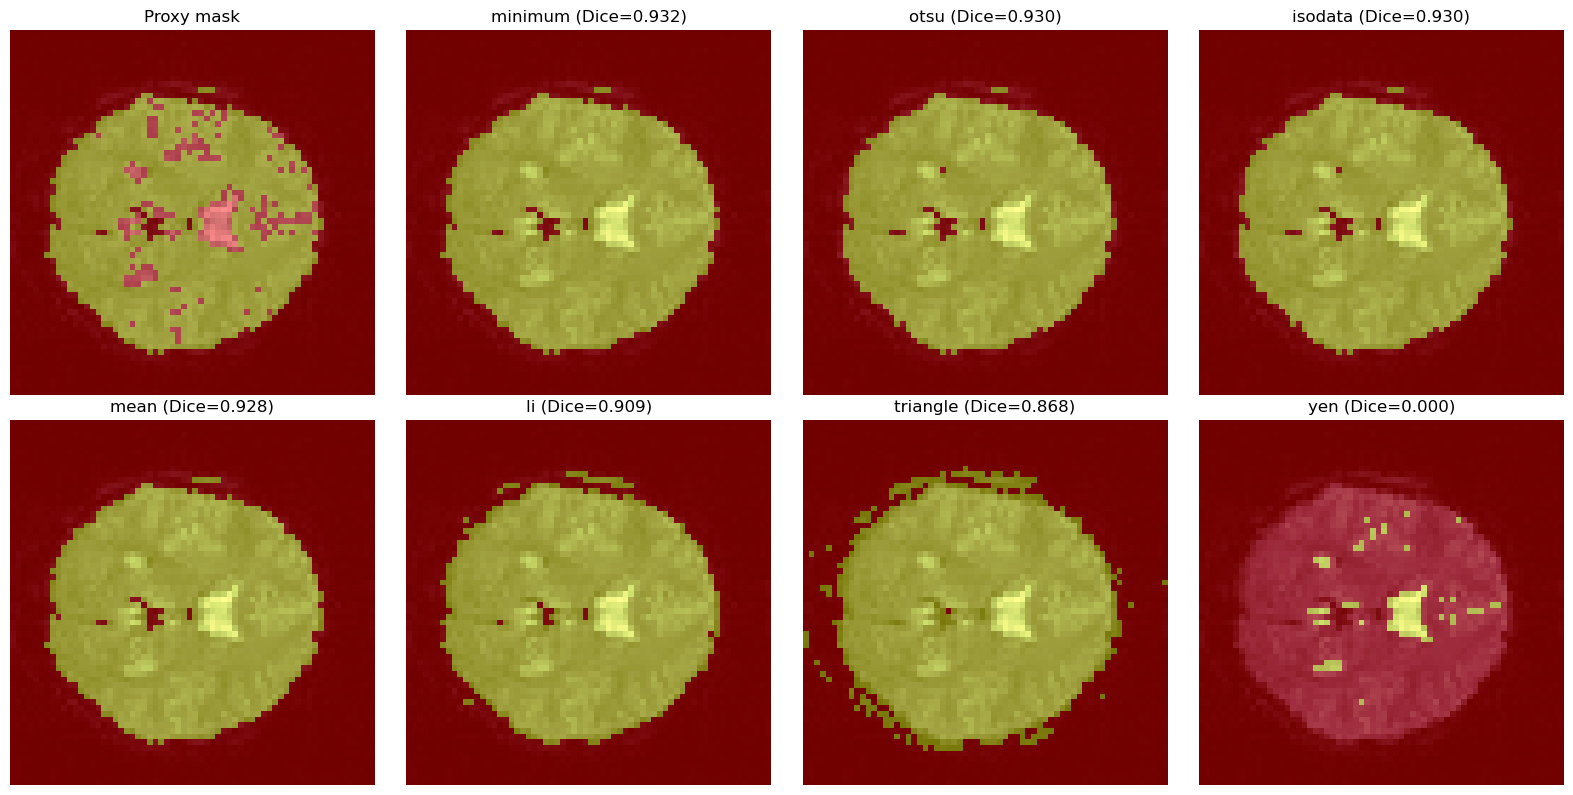

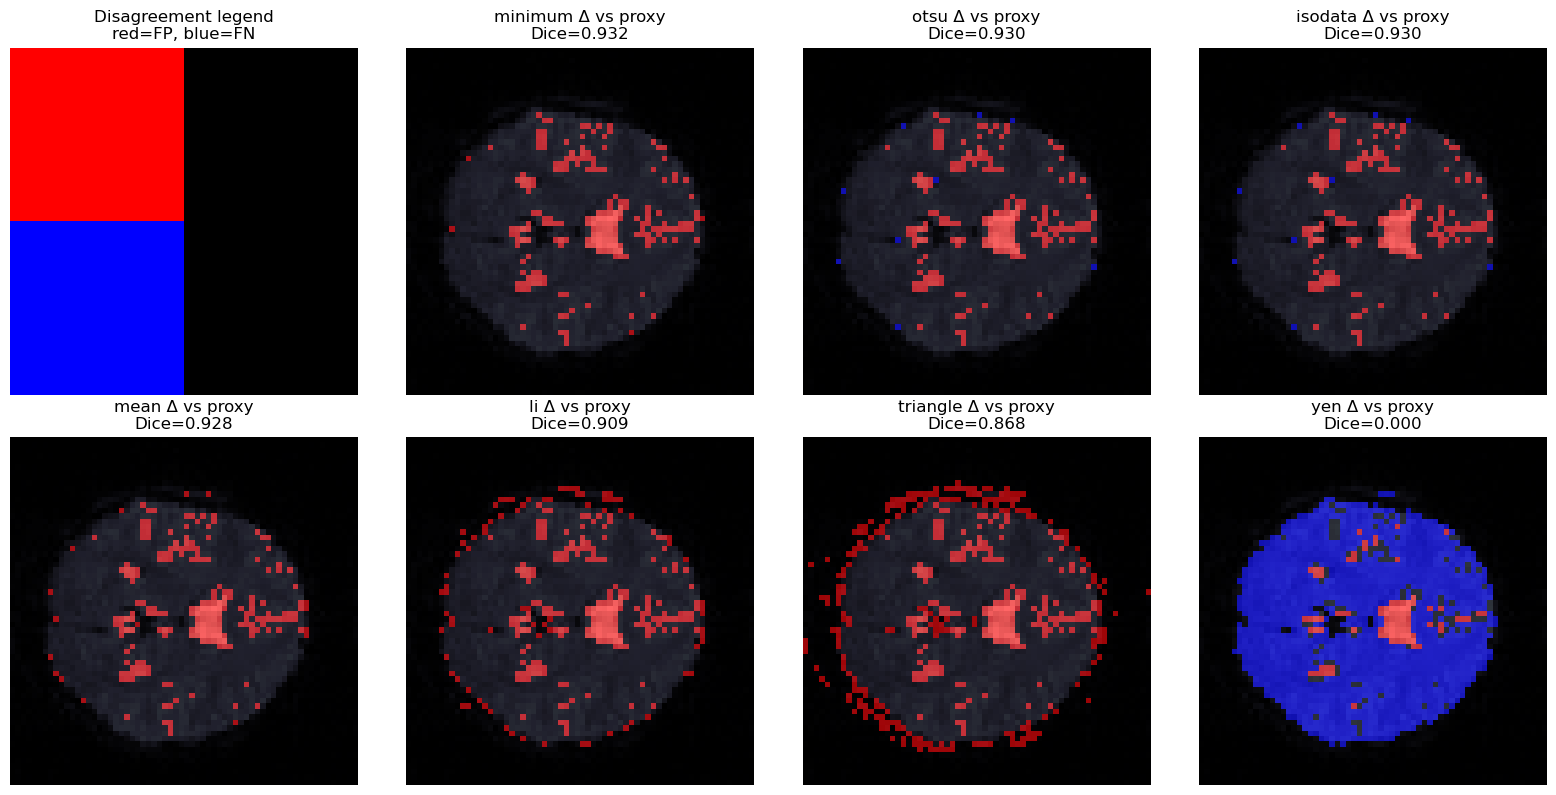

Dice scores (vs proxy):
  minimum  : 0.9318
  otsu     : 0.9299
  isodata  : 0.9299
  mean     : 0.9282
  li       : 0.9091
  triangle : 0.8684
  yen      : 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import (
    threshold_otsu, threshold_yen, threshold_li,
    threshold_triangle, threshold_isodata, threshold_minimum, threshold_mean,
    threshold_multiotsu
)
from skimage.morphology import remove_small_objects, remove_small_holes

# -----------------------
# 1) Choose a PROXY mask
# -----------------------
USE_MULTI_OTSU_PROXY = True  # set False to use morphology-cleaned Otsu proxy

if USE_MULTI_OTSU_PROXY:
    t1, t2 = threshold_multiotsu(slice10, classes=3)
    proxy_mask = ((slice10 > t1) & (slice10 <= t2)).astype(np.uint8)  # mid class = "tissue"
else:
    otsu_val = threshold_otsu(slice10)
    proxy_mask = (slice10 > otsu_val)
    # light cleanup to approximate a good brain mask (tune min sizes if needed)
    proxy_mask = remove_small_objects(proxy_mask, 100)
    proxy_mask = remove_small_holes(proxy_mask, 100)
    proxy_mask = proxy_mask.astype(np.uint8)

# -----------------------
# 2) Build candidate masks
# -----------------------
th_funcs = {
    "mean":     threshold_mean,
    "otsu":     threshold_otsu,
    "yen":      threshold_yen,
    "li":       threshold_li,
    "triangle": threshold_triangle,
    "isodata":  threshold_isodata,
    "minimum":  threshold_minimum,
}

masks = {}
for name, fn in th_funcs.items():
    try:
        t = fn(slice10)
        masks[name] = (slice10 > t).astype(np.uint8)
    except Exception as e:
        print(f"[warn] {name} failed: {e}")

# -----------------------
# 3) Metrics
# -----------------------
def dice(a, b):
    inter = np.logical_and(a==1, b==1).sum()
    return (2*inter) / (a.sum() + b.sum() + 1e-9)

scores = {name: dice(m, proxy_mask) for name, m in masks.items()}
# Sort by Dice descending
items = sorted(masks.items(), key=lambda kv: scores[kv[0]], reverse=True)

# -----------------------
# 4) Overlay gallery (proxy + each method)
# -----------------------
def overlay(ax, base, mask, title="", cmap_base="bone"):
    ax.imshow(base, cmap=cmap_base)
    ax.imshow(mask, alpha=0.45, cmap="autumn")  # orange mask overlay
    ax.set_title(title)
    ax.axis("off")

cols = min(4, len(items)+1)
rows = int(np.ceil((len(items)+1) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = np.array(axes).reshape(rows, cols)

# First panel: proxy itself
overlay(axes.flat[0], slice10, proxy_mask, title="Proxy mask")
# Remaining panels: candidates with Dice in title
for ax, (name, m) in zip(axes.flat[1:], items):
    overlay(ax, slice10, m, title=f"{name} (Dice={scores[name]:.3f})")

# Hide any unused axes
for k in range(1+len(items), rows*cols):
    axes.flat[k].axis("off")

plt.tight_layout(); plt.show()

# -----------------------
# 5) Disagreement maps (FP=red, FN=blue)
# -----------------------
def disagreement_rgb(candidate, reference):
    # FP = candidate==1 & ref==0 -> red channel
    # FN = candidate==0 & ref==1 -> blue channel
    fp = np.logical_and(candidate==1, reference==0)
    fn = np.logical_and(candidate==0, reference==1)
    rgb = np.zeros((candidate.shape[0], candidate.shape[1], 3), dtype=float)
    rgb[..., 0] = fp.astype(float)  # red
    rgb[..., 2] = fn.astype(float)  # blue
    return rgb

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = np.array(axes).reshape(rows, cols)

# First panel: legend
axes.flat[0].imshow(np.dstack([
    np.array([[1,0],[0,0]], float),  # red=FP
    np.zeros((2,2), float),
    np.array([[0,0],[1,0]], float)   # blue=FN
]))
axes.flat[0].set_title("Disagreement legend\nred=FP, blue=FN")
axes.flat[0].axis("off")

for ax, (name, m) in zip(axes.flat[1:], items):
    rgb = disagreement_rgb(m, proxy_mask)
    ax.imshow(slice10, cmap="bone")
    ax.imshow(rgb, alpha=0.6)
    ax.set_title(f"{name} Δ vs proxy\nDice={scores[name]:.3f}")
    ax.axis("off")

for k in range(1+len(items), rows*cols):
    axes.flat[k].axis("off")

plt.tight_layout(); plt.show()

# -----------------------
# 6) Print ranked scores
# -----------------------
print("Dice scores (vs proxy):")
for name, _ in items:
    print(f"  {name:9s}: {scores[name]:.4f}")


**How to read the figures**

* **Overlay gallery**: each panel shows the mask (orange) over the slice; title shows **Dice vs proxy**.
* **Disagreement maps**:

  * **Red** = false positives (method includes voxels proxy does not).
  * **Blue** = false negatives (method misses voxels proxy includes).

This gives you both a **quantitative ranking** and an **explainable visual** for why some methods perform better on your brain slice.



# 📌 2 Edge-Based Segmentation

## Concept

While **threshold-based segmentation** assumes different regions have different pixel intensity distributions, **edge-based segmentation** leverages the fact that objects are usually separated by **boundaries (edges)**.

* **Edges** = points where intensity changes abruptly.
* These can occur at the **brain–air boundary**, **skull–tissue boundary**, or **tissue–ventricle boundary** in fMRI slices.
* Detecting edges gives us structural outlines, which we can then use to build segmentation masks.

---

## Canny Edge Detector

One of the most widely used edge detection algorithms is the **Canny detector** (John Canny, 1986). It works in several stages:

1. **Smoothing**: Apply a Gaussian blur to reduce noise (small fluctuations won’t be falsely marked as edges).
2. **Gradient detection**: Use filters like Sobel to measure intensity changes.
3. **Non-maximum suppression**: Keep only local maxima of gradients, thinning edges to 1-pixel width.
4. **Double thresholding**: Distinguish strong edges from weak ones.
5. **Edge tracking by hysteresis**: Keep weak edges only if they are connected to strong edges.

Result = a binary edge map (1 = edge, 0 = not edge).

---

## Code Example on fMRI Slice

skimage.feature.canny(image,
                    sigma=1.0,
                     low_threshold=None,
                      high_threshold=None, 
                      mask=None,
                       use_quantiles=False, 
                       mode='constant', 
                       cval=0.0)

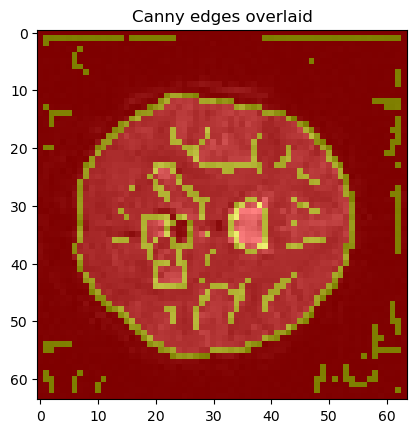

In [ ]:
from skimage.feature import canny
import matplotlib.pyplot as plt

# Run Canny edge detection
edges = canny(slice10, sigma=2.0)   # sigma controls smoothing
fig, ax = plt.subplots()
ax.imshow(slice10, cmap="gray")
ax.imshow(edges, alpha=0.5, cmap="autumn")
ax.set_title("Canny edges overlaid")
plt.show()



* The `sigma` parameter controls the level of Gaussian smoothing.
* Larger `sigma` → smoother edges, less sensitivity to small details.
* Smaller `sigma` → captures fine edges but may be noisy.

---

## Post-Processing Edges with Morphology

Edges alone don’t form a segmentation mask. We need to **fill regions enclosed by edges** and remove spurious fragments.

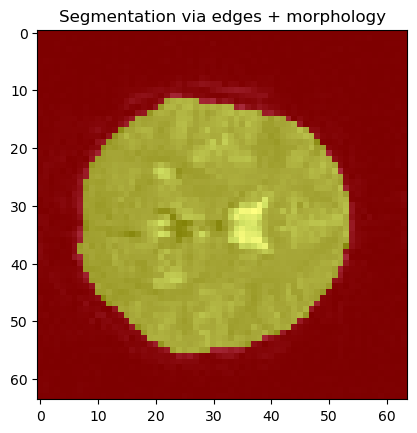

In [ ]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import erosion, remove_small_objects

# Fill holes inside edges, erode, and clean up small fragments
segmentation = remove_small_objects(
    erosion(binary_fill_holes(edges)), min_size=100
)

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
ax.imshow(segmentation, alpha=0.5, cmap="autumn")
ax.set_title("Segmentation via edges + morphology")
plt.show()

## Strengths & Weaknesses

✅ Strengths:

* Captures **structural boundaries** well (e.g., separating brain from air/skull).
* Robust to variations in absolute intensity (works on both dark–light and light–dark transitions).

⚠️ Limitations:

* May **detect internal structures** (e.g., ventricles, sulci) that you don’t want segmented.
* Requires **morphological cleanup** to produce usable masks.
* Performance may vary across slices (good in some, fails in others).

---

## Neuroimaging Implications

* **Skull-stripping**: Edge-based methods can help separate brain from non-brain tissues.
* **Structural boundaries**: Useful for detecting ventricles, cortical edges, lesions.
* **Preprocessing**: Often combined with intensity-based methods for more robust brain extraction.
* **Limitations in practice**: Real pipelines (e.g., FreeSurfer, FSL BET, AFNI) combine **edge detection + intensity models + anatomical priors**, not just Canny.

---

✨ **Exercise**: Try running the Canny + morphology pipeline across multiple slices:

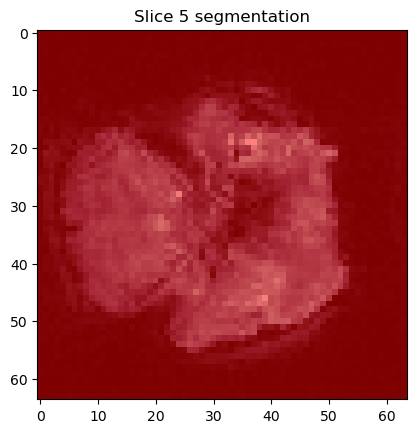

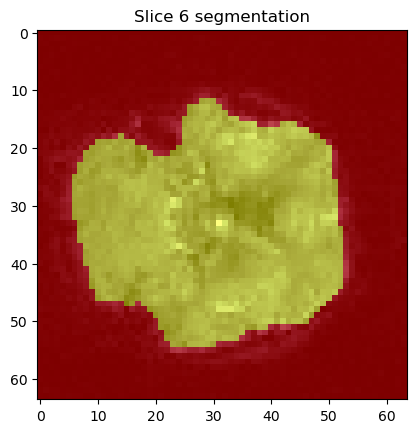

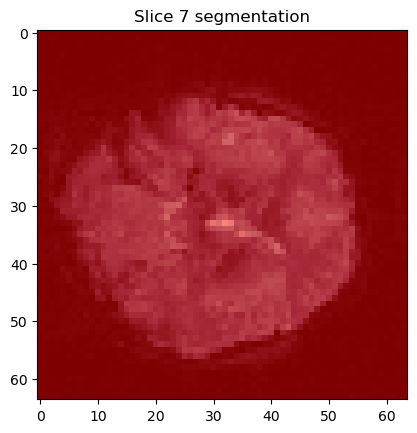

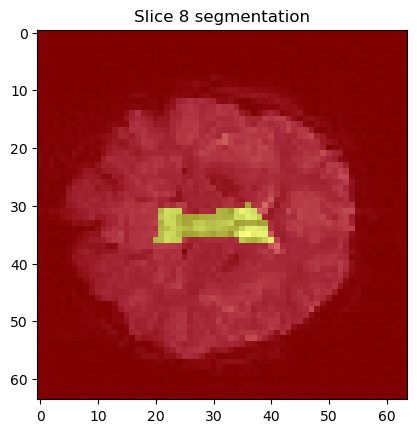

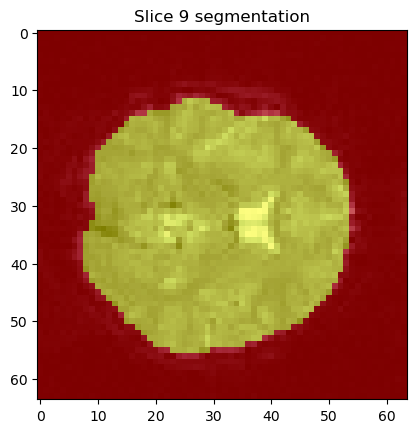

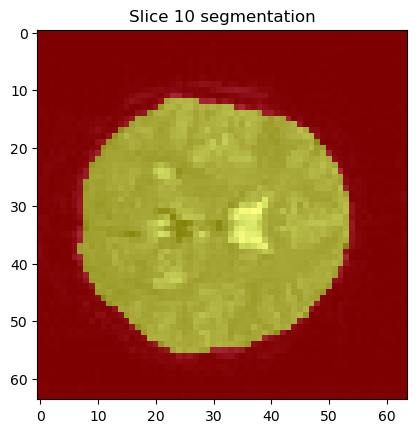

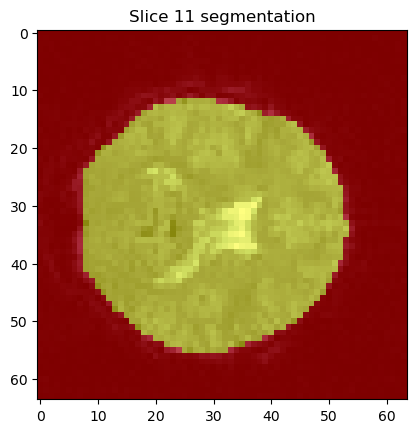

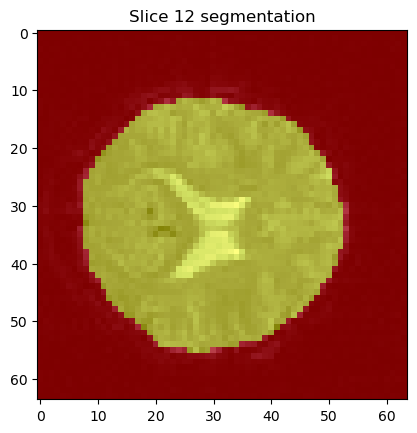

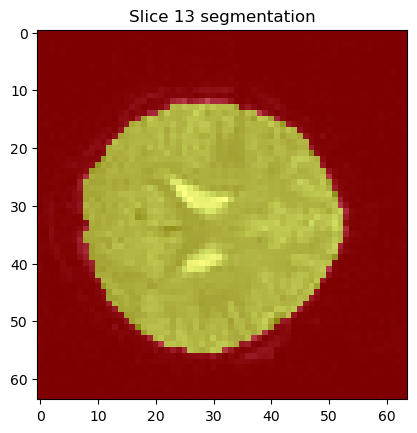

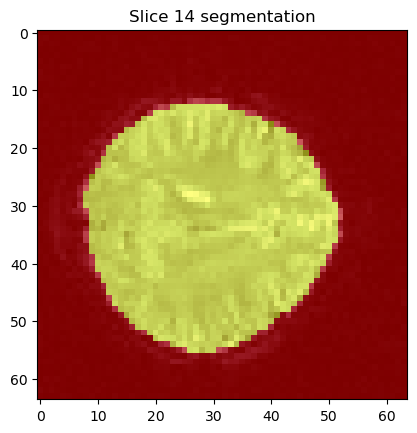

In [ ]:
for i in range(5, 15):   # loop over slices
    edges = canny(brain[:,:,i], sigma=2.0)
    seg = remove_small_objects(erosion(binary_fill_holes(edges)))
    
    fig, ax = plt.subplots()
    ax.imshow(brain[:,:,i], cmap="bone")
    ax.imshow(seg, alpha=0.5, cmap="autumn")
    ax.set_title(f"Slice {i} segmentation")
    plt.show()

 **compares intensity-based (Otsu) vs edge-based (Canny + morphology)** on the same slice. It makes two figures:

1. **Side-by-side overlays** (Original, Otsu, Edge-based)
2. **Disagreement map** (red = Otsu extra, blue = Edge-based extra)



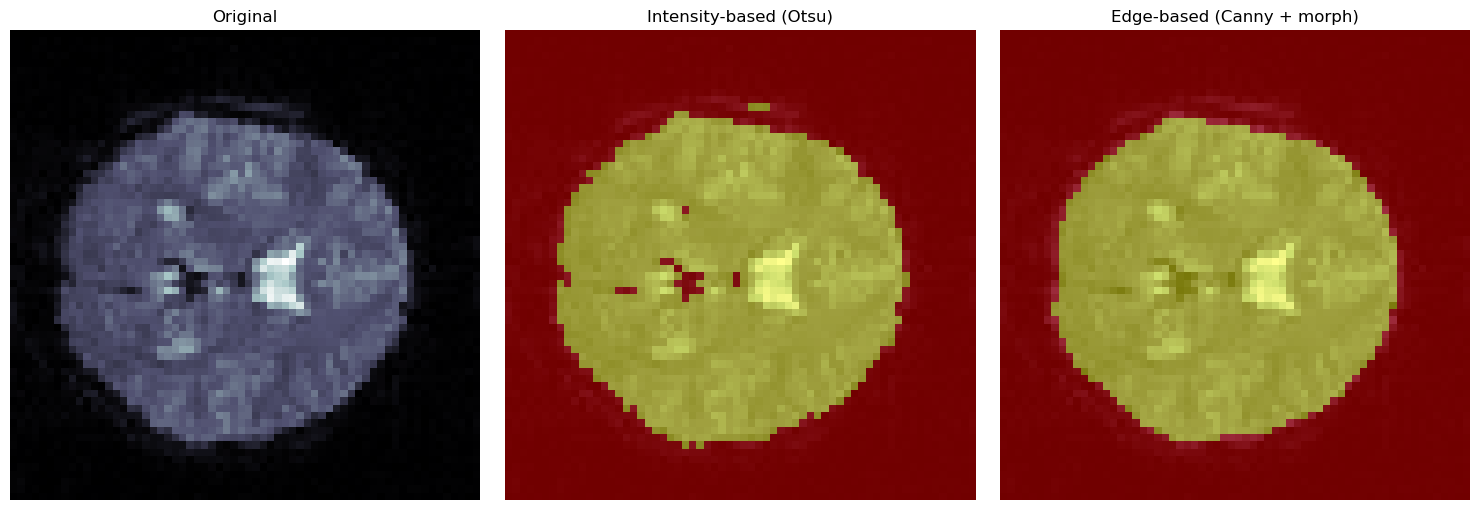

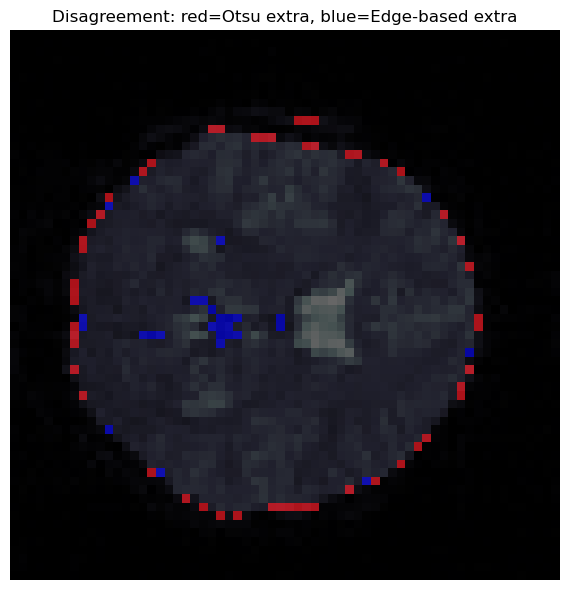

Dice(Otsu, Edge-based) = 0.975
Otsu extra (red)  pixels: 53
Edge extra (blue) pixels: 28


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.feature import canny
from scipy.ndimage import binary_fill_holes
from skimage.morphology import erosion, remove_small_objects

# ---------------------------
# 1) Build the two segmenters
# ---------------------------

def seg_otsu(img):
    t = threshold_otsu(img)
    return (img > t).astype(np.uint8)

def seg_edge_based(img, sigma=2.0, min_size=100, erode=True):
    # Canny edges
    E = canny(img, sigma=sigma)
    # Fill enclosed regions
    filled = binary_fill_holes(E)
    # (optional) erode to trim 1-px edge rims
    mask = erosion(filled) if erode else filled
    # remove tiny fragments
    mask = remove_small_objects(mask.astype(bool), min_size=min_size)
    return mask.astype(np.uint8)

# Build masks
mask_otsu = seg_otsu(slice10)
mask_edge = seg_edge_based(slice10, sigma=2.0, min_size=120, erode=True)

# ---------------------------
# 2) Side-by-side comparison
# ---------------------------
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(slice10, cmap="bone"); ax[0].set_title("Original"); ax[0].axis("off")

ax[1].imshow(slice10, cmap="bone")
ax[1].imshow(mask_otsu, alpha=0.45, cmap="autumn")
ax[1].set_title("Intensity-based (Otsu)"); ax[1].axis("off")

ax[2].imshow(slice10, cmap="bone")
ax[2].imshow(mask_edge, alpha=0.45, cmap="autumn")
ax[2].set_title("Edge-based (Canny + morph)"); ax[2].axis("off")

plt.tight_layout(); plt.show()

# ---------------------------
# 3) Disagreement visualization
#    red  = Otsu includes but Edge-based excludes (FP vs edge-based)
#    blue = Edge-based includes but Otsu excludes (FN vs edge-based)
# ---------------------------
fp = np.logical_and(mask_otsu==1, mask_edge==0)  # red
fn = np.logical_and(mask_otsu==0, mask_edge==1)  # blue

rgb = np.zeros((slice10.shape[0], slice10.shape[1], 3), dtype=float)
rgb[..., 0] = fp.astype(float)   # red channel
rgb[..., 2] = fn.astype(float)   # blue channel

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(slice10, cmap="bone")
ax.imshow(rgb, alpha=0.6)
ax.set_title("Disagreement: red=Otsu extra, blue=Edge-based extra")
ax.axis("off")
plt.tight_layout(); plt.show()

# ---------------------------
# 4) (Optional) quick numbers
# ---------------------------
def dice(a, b):
    inter = np.logical_and(a==1, b==1).sum()
    return (2*inter) / (a.sum() + b.sum() + 1e-9)

print(f"Dice(Otsu, Edge-based) = {dice(mask_otsu, mask_edge):.3f}")
print(f"Otsu extra (red)  pixels: {fp.sum()}")
print(f"Edge extra (blue) pixels: {fn.sum()}")


### How to read the results

* **Otsu (intensity)**: great at removing air, but often **includes skull & ventricles** (bright).
* **Edge-based**: tends to capture the **brain boundary** better (can drop skull), but may **miss** interior brain where edges are weak unless you tune `sigma`, `min_size`, and add smoothing beforehand.

### Tips to tune

* `sigma` (Canny): ↑sigma → smoother, fewer spurious edges; ↓sigma → more detail, more noise.
* `min_size` (remove\_small\_objects): raise to delete tiny specks; lower to keep small structures.
* Pre-smoothing with a small Gaussian (`filters.gaussian(slice10, 1)`) can stabilize both Otsu and Canny.




## ✅ Methods we’ve already covered

### 1. **Thresholding (Intensity-Based)**

* Principle: cut the histogram of intensities at one or more thresholds.
* We walked through:

  * **Mean thresholding** (simple, but crude).
  * **Otsu’s method** (variance minimization, automatically finds the “best” threshold).
  * **Multi-Otsu** (splits into >2 classes, e.g., separating ventricles from GM/WM).
  * Also: compared several Scikit-Image thresholds with `try_all_threshold`.
* **Usefulness**:

  * Good at separating background (air) vs. tissue.
  * Weak at finer distinctions (skull vs. brain, gray matter vs. white matter).
  * Still widely used for quick masks (e.g., brain extraction, removing background).

### 2. **Edge-Based Methods**

* Principle: look for **boundaries** where intensity changes sharply.
* We covered:

  * **Sobel filter** (gradient-based edges).
  * **Canny detector** (multi-step: smooth → gradients → suppress non-max → threshold edges → connect strong/weak).
  * Post-processing with **morphological filling + cleanup** to turn edge maps into segmentations.
* **Usefulness**:

  * Captures skull/air boundaries better than thresholds.
  * Handles edges across both low–high and high–low ranges.
  * Still misses interior structures (e.g., ventricles) unless tuned carefully.

---

## 🚀 What’s coming next

### 3. **Region-Based Segmentation**

* Starts from “seed” points and **grows** regions based on similarity (intensity, texture).
* Good for smooth, continuous structures (ventricles, lesions).
* Sensitive to noise, choice of seed points.
* Example: `skimage.segmentation.flood` or `flood_fill`.

### 4. **Advanced Methods**

* **Morphological segmentation**: use erosion/dilation/opening/closing to refine masks.
* **Clustering**: k-means, Gaussian mixture models (can classify voxels into GM/WM/CSF by intensity distributions).
* **Machine Learning / CNNs**: modern pipelines (U-Net, DeepLab, etc.) trained on large annotated brain datasets.
* These combine image statistics with **anatomical priors** for robust results.

---







# **BONUS**






# 📌 3 Region-Based Segmentation

## Why region-based?

Thresholds and edges look at **local intensity** or **local gradients**. Region-based methods use **spatial coherence**: pixels that “belong together” should be **connected** and have **similar** intensities. You provide one or more **seeds**, and the algorithm **grows** regions that are similar to the seed(s) (flood/fill), or **floods** the image from multiple labeled seeds until basins meet (watershed).

---

## 3.1 Flood / Flood-Fill (Region Growing)

### Idea

Pick a **seed pixel** inside the structure of interest (e.g., inside brain), then **grow** to neighboring pixels that are within a **tolerance** of the seed intensity. You can do this with `skimage.segmentation.flood` or directly write a small BFS/DFS; `flood_fill` returns a *filled image*, while `flood` returns a *boolean mask*.

### A) Single-seed demo (tune tolerance)

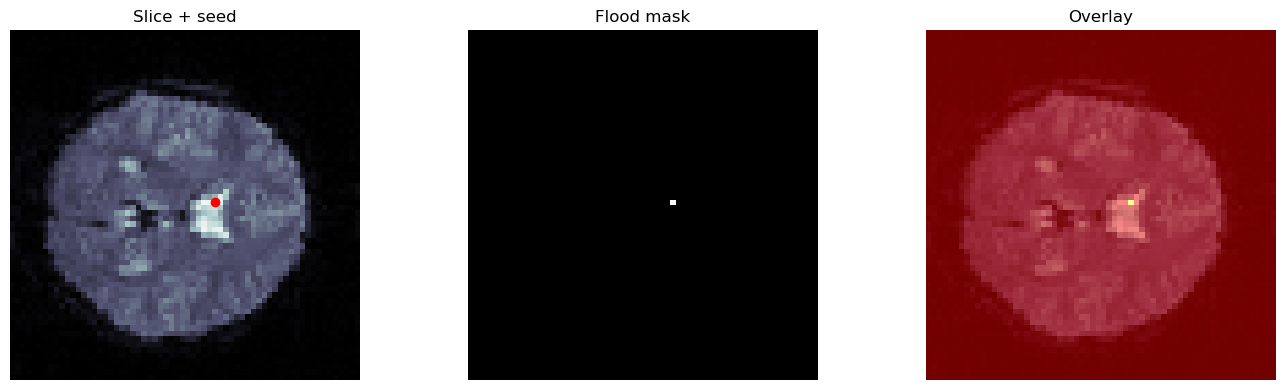

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood

# ----- choose a seed -----
# heuristic: take the location of the maximum intensity in the central band (likely inside brain tissue)
H, W = slice10.shape
band = slice10[:, W//4:3*W//4]
iy, ix_local = np.unravel_index(np.argmax(band), band.shape)
seed = (iy, ix_local + W//4)  # (row, col)

# ----- grow a region with a tolerance -----
# tolerance ~ how far intensities can deviate from seed intensity
mask_flood = flood(slice10, seed_point=seed, tolerance=0.1)  # try 0.08..0.15 depending on contrast

fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].imshow(slice10, cmap="bone"); ax[0].plot(seed[1], seed[0], 'ro', ms=6); ax[0].set_title("Slice + seed"); ax[0].axis("off")
ax[1].imshow(mask_flood, cmap="gray"); ax[1].set_title("Flood mask"); ax[1].axis("off")
ax[2].imshow(slice10, cmap="bone"); ax[2].imshow(mask_flood, alpha=0.45, cmap="autumn"); ax[2].set_title("Overlay"); ax[2].axis("off")
plt.tight_layout(); plt.show()

**What to tune**

* `tolerance`: ↑ grows more (risk leakage into skull/CSF), ↓ grows less (risk holes).
* `seed`: choose a robust seed — inside brain parenchyma (mid-intensity), not ventricles/skull.

### B) Multi-seed flood (safer)

Run flood from several seeds spread through the brain and **OR** the results; still constrained by intensity similarity.


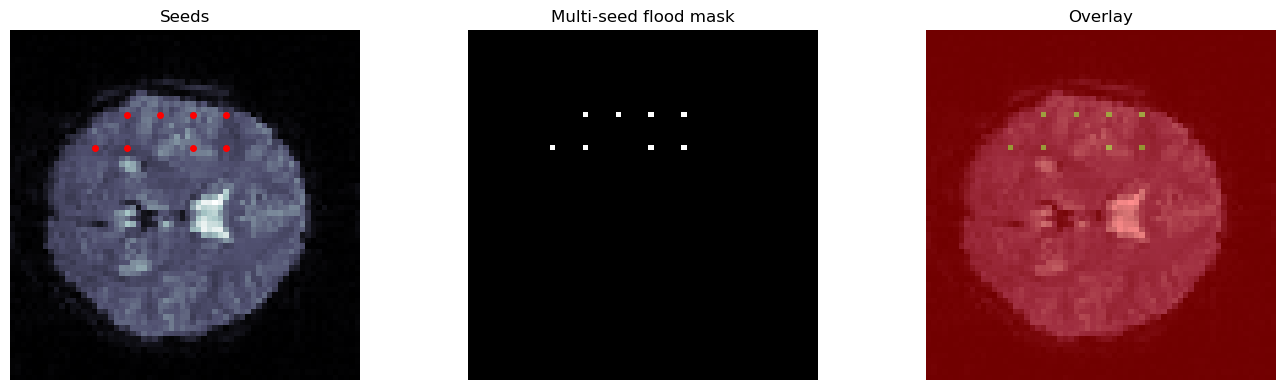

In [ ]:
from skimage.filters import threshold_multiotsu

# use Multi-Otsu to locate the "tissue" band, then pick a few seeds from it
t1, t2 = threshold_multiotsu(slice10, classes=3)
tissue = (slice10 > t1) & (slice10 <= t2)

# pick N seeds by sampling the tissue mask on a coarse grid
seeds = []
step = max(1, min(slice10.shape)//10)  # coarse stride
for y in range(step//2, H, step):
    for x in range(step//2, W, step):
        if tissue[y, x]:
            seeds.append((y, x))
        if len(seeds) >= 8:  # take up to 8 seeds
            break
    if len(seeds) >= 8:
        break

# grow from each seed and combine
mask_multi = np.zeros_like(slice10, dtype=bool)
for s in seeds:
    mask_multi |= flood(slice10, seed_point=s, tolerance=0.08)  # slightly stricter tolerance

fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].imshow(slice10, cmap="bone"); 
for s in seeds: ax[0].plot(s[1], s[0], 'ro', ms=4)
ax[0].set_title("Seeds"); ax[0].axis("off")
ax[1].imshow(mask_multi, cmap="gray"); ax[1].set_title("Multi-seed flood mask"); ax[1].axis("off")
ax[2].imshow(slice10, cmap="bone"); ax[2].imshow(mask_multi, alpha=0.45, cmap="autumn"); ax[2].set_title("Overlay"); ax[2].axis("off")
plt.tight_layout(); plt.show()

**Pros/Cons**

* ✅ Simple, intuitive; preserves smooth regions (ventricles/lesions if seeded).
* ⚠️ Sensitive to **tolerance** and **seed placement**; can leak across thin boundaries if intensities are similar.

---

## 3.2 Watershed (Markers + Distance / Gradient)

### Idea

Treat the image as a **topographic surface**. Place **markers** for regions (foreground/background). “Fill with water” from markers; basins grow until they meet along **watershed lines**, which become **boundaries**.

Two common formulations:

1. **Distance-based watershed** (great for separating **touching blobs**)

   * Start from a **binary mask** (e.g., thresholded brain).
   * Compute **distance transform** inside the mask.
   * Find local maxima → **foreground markers**.
   * Use watershed on **-distance** to split into components.

2. **Gradient-based watershed** (great for **boundary-driven** segmentation)

   * Compute a **gradient image** (e.g., Sobel magnitude, or Canny map as cost).
   * Provide **markers** for foreground and background.
   * Watershed on the gradient: it prefers to stop at strong edges.

Below are both.

### A) Distance-based watershed (binary → components)

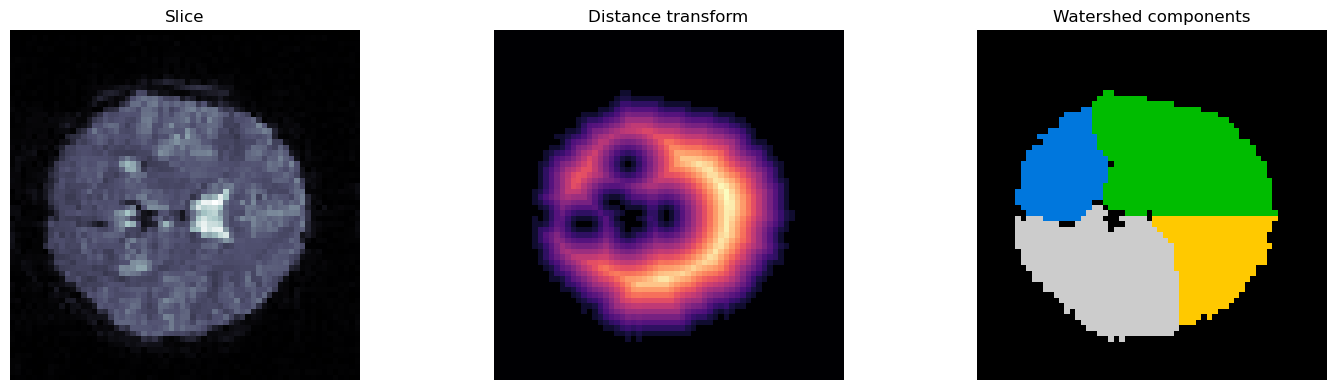

In [ ]:
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects

# 1) start with a binary "brain-ish" mask (Otsu + cleanup)
t = threshold_otsu(slice10)
brainish = slice10 > t
brainish = remove_small_objects(brainish, 100)

# 2) distance transform inside the mask
dist = ndi.distance_transform_edt(brainish)

# 3) find local maxima as markers (tune footprint / min_distance)
coords = peak_local_max(dist, labels=brainish, footprint=np.ones((9,9)), min_distance=6)
markers = np.zeros_like(slice10, dtype=int)
for i, (r, c) in enumerate(coords, start=1):
    markers[r, c] = i
markers = ndi.label(markers)[0]  # ensure contiguous labels

# 4) watershed on -distance (so basins grow from peaks)
labels_ws = watershed(-dist, markers, mask=brainish)

fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(slice10, cmap="bone"); ax[0].set_title("Slice"); ax[0].axis("off")
ax[1].imshow(dist, cmap="magma"); ax[1].set_title("Distance transform"); ax[1].axis("off")
ax[2].imshow(labels_ws, cmap="nipy_spectral"); ax[2].set_title("Watershed components"); ax[2].axis("off")
plt.tight_layout(); plt.show()

**Use cases**: split touching structures **inside** a foreground mask (e.g., separate ventricles from tissue if you pre-bin them, or split multiple lesions).

### B) Gradient-based watershed (markers for FG/BG)

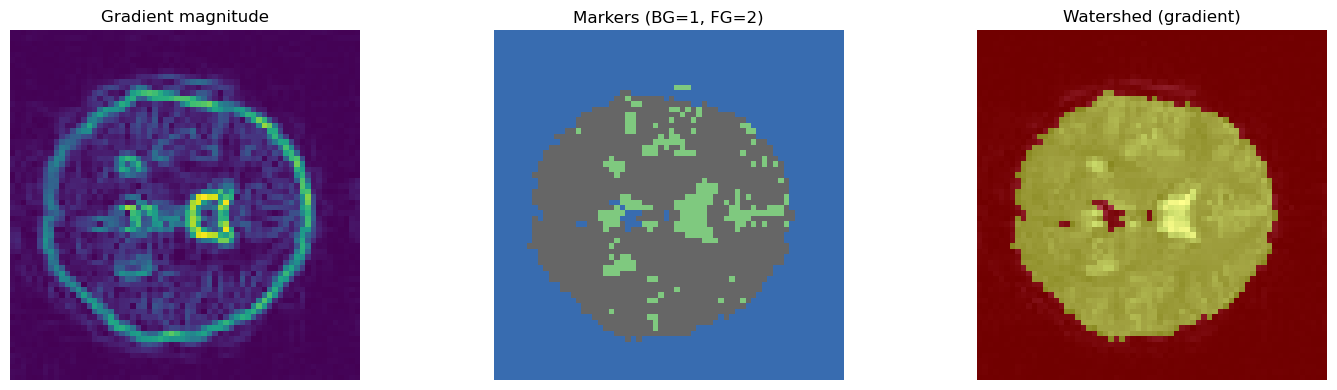

In [ ]:
from skimage.filters import sobel
from skimage.measure import label

# 1) cost image = gradient magnitude (edges are "ridges" to stop flooding)
grad = sobel(slice10)

# 2) build markers
# foreground: mid-intensity “tissue” class (Multi-Otsu)
from skimage.filters import threshold_multiotsu
t1, t2 = threshold_multiotsu(slice10, classes=3)
fg = (slice10 > t1) & (slice10 <= t2)
fg = remove_small_objects(fg, 100)

# background: sure background (very dark)
bg = slice10 <= t1

markers = np.zeros_like(slice10, dtype=np.int32)
markers[bg] = 1
markers[fg] = 2  # two classes: 1=background, 2=foreground (brain-ish)

# 3) watershed on gradient with FG/BG markers
seg_ws = watershed(grad, markers=markers)
mask_ws = (seg_ws == 2)

fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(grad, cmap="viridis"); ax[0].set_title("Gradient magnitude"); ax[0].axis("off")
ax[1].imshow(markers, cmap="Accent"); ax[1].set_title("Markers (BG=1, FG=2)"); ax[1].axis("off")
ax[2].imshow(slice10, cmap="bone"); ax[2].imshow(mask_ws, alpha=0.45, cmap="autumn"); ax[2].set_title("Watershed (gradient)"); ax[2].axis("off")
plt.tight_layout(); plt.show()


**Use cases**: brain extraction with **edge guidance**; separation where **intensity alone fails** but edges are strong.

---

## Practical tips (fMRI / MRI)

* **Flood / flood\_fill**

  * Great for **interactive** region growing from a seed (e.g., ventricle seed to get CSF).
  * Sensitive to **tolerance** and **seed**; pre-smooth slightly (Gaussian σ≈1) to stabilize.

* **Watershed**

  * **Distance-based**: best when you already have a **binary mask** and need to **split** internal parts.
  * **Gradient-based**: good for **boundary-aware** masks; relies on good **markers**.
  * Always sanity-check with **morphology** (remove small objects/holes, opening/closing).

* **3D data**

  * All of the above generalize to **3D**: run on volumes; use **3D footprints** (e.g., `ball`) and 3D distance transforms.
  * For watershed, pass a 3D `markers` array and 3D `mask/cost`; visualization uses orthogonal slices.

---

## Quick side-by-side: Otsu vs Flood vs Watershed (gradient)

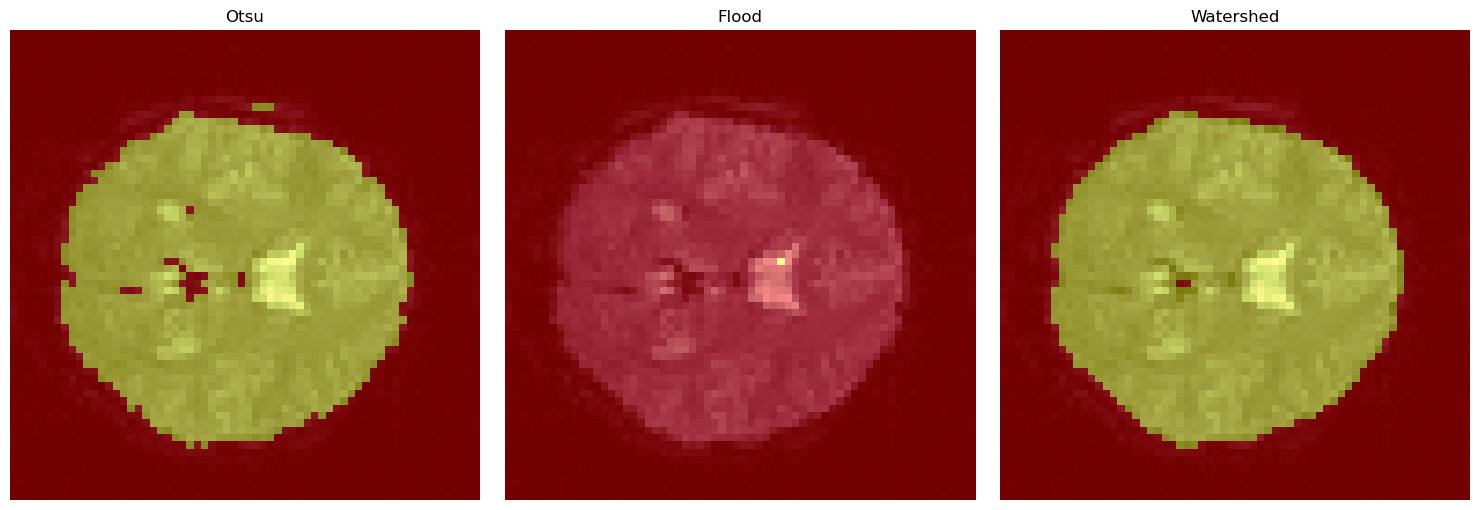

In [ ]:
# Build three masks to compare quickly:
from skimage.filters import threshold_otsu, gaussian

# Intensity-only
mask_otsu = slice10 > threshold_otsu(slice10)

# Flood (seed + tolerance) on a slightly smoothed slice for stability
smooth = gaussian(slice10, sigma=1, preserve_range=True)
mask_flood = flood(smooth, seed_point=seed, tolerance=0.08)

# Watershed (gradient) with FG/BG markers from Multi-Otsu
grad = sobel(smooth)
t1, t2 = threshold_multiotsu(smooth, classes=3)
fg = remove_small_objects((smooth > t1) & (smooth <= t2), 100)
bg = smooth <= t1
markers = np.zeros_like(slice10, dtype=np.int32); markers[bg]=1; markers[fg]=2
mask_ws = (watershed(grad, markers=markers) == 2)

# Show overlays
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for a, (title, m) in zip(ax, [("Otsu", mask_otsu), ("Flood", mask_flood), ("Watershed", mask_ws)]):
    a.imshow(slice10, cmap="bone"); a.imshow(m, alpha=0.45, cmap="autumn"); a.set_title(title); a.axis("off")
plt.tight_layout(); plt.show()

### TL;DR

* **Flood / flood\_fill**: grow from seed(s) with a similarity tolerance — simple, intuitive, but seed/tolerance sensitive.
* **Watershed**: powerful marker-driven method — either distance-based (split blobs) or gradient-based (edge-aware).
* Combine with **light smoothing** and **morphology** to get robust, clean masks.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood, watershed
from scipy import ndimage as ndi

def run_region_methods(img, seeds=None, flood_tol=0.05,
                       markers=None, grad_sigma=1.0,
                       gt_mask=None, show=True):
    """
    Run region-based segmentation (flood fill + watershed).
    
    Parameters
    ----------
    img : 2D ndarray
        Input grayscale image (e.g. brain slice).
    seeds : list of (row, col)
        Seed coordinates for flood fill. If None, skip flood.
    flood_tol : float
        Relative tolerance for flood fill.
    markers : 2D ndarray
        Predefined markers for watershed (same size as img).
    grad_sigma : float
        Gaussian smoothing for gradient in watershed.
    gt_mask : 2D ndarray (optional)
        Ground-truth binary mask for Dice scoring.
    show : bool
        Whether to plot results.
    
    Returns
    -------
    results : dict
        {"flood": mask, "watershed": mask, "scores": {...}}
    """
    results = {}

    # --- Flood fill
    if seeds is not None:
        mask_flood = np.zeros_like(img, dtype=bool)
        for s in seeds:
            mask_flood |= flood(img, seed_point=s, tolerance=flood_tol*np.ptp(img))
        results["flood"] = mask_flood.astype(np.uint8)
    
    # --- Watershed
    grad = ndi.gaussian_gradient_magnitude(img, grad_sigma)
    if markers is None:
        markers = np.zeros_like(img, dtype=np.int32)
        markers[img < np.percentile(img, 10)] = 1  # background
        markers[img > np.percentile(img, 90)] = 2  # foreground
    mask_ws = watershed(grad, markers)
    results["watershed"] = (mask_ws > 1).astype(np.uint8)

    # --- Optional Dice scores
    if gt_mask is not None:
        def dice(a, b):
            inter = np.logical_and(a==1, b==1).sum()
            return (2*inter) / (a.sum() + b.sum() + 1e-9)
        scores = {k: dice(v, gt_mask) for k, v in results.items()}
        results["scores"] = scores
        print("Dice scores:", scores)

    # --- Visualization
    if show:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(img, cmap="gray"); axes[0].set_title("Original")
        if "flood" in results:
            axes[1].imshow(results["flood"], cmap="gray"); axes[1].set_title("Flood")
        else:
            axes[1].axis("off")
        axes[2].imshow(results["watershed"], cmap="gray"); axes[2].set_title("Watershed")
        plt.tight_layout(); plt.show()

    return results


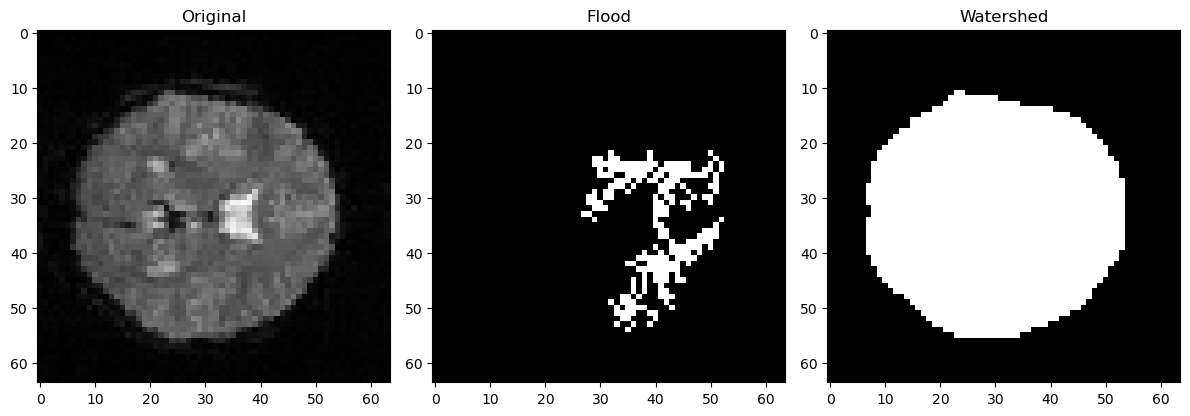

In [ ]:
# Example on your brain slice
seeds = [(30, 32), (35, 40)]   # pick manually or programmatically
res = run_region_methods(slice10, seeds=seeds, flood_tol=0.03)

# With optional ground-truth mask (if you have one)
# res = run_region_methods(slice10, seeds=seeds, flood_tol=0.03,
#                          gt_mask=gt_mask)


In [ ]:
import numpy as np
from skimage.filters import gaussian, threshold_multiotsu
from skimage.segmentation import flood
from skimage.morphology import disk, binary_closing, remove_small_objects

def flood_brain_2d(img, seed, sigma=1.0,
                   use_mask=True, min_obj=150,
                   tol_mode="local", tol_val=1.0,
                   connectivity=2):
    """
    img: 2D slice, ideally float in [0,1]
    seed: (row, col)
    sigma: Gaussian smoothing for stability
    use_mask: restrict growth to a tissue-like pre-mask (Multi-Otsu middle band)
    tol_mode: "local" -> k*local_std; "abs" -> absolute tolerance value
    tol_val: if local -> k (e.g., 1.0..2.0); if abs -> absolute tol (e.g., 0.08)
    connectivity: 1 (4-neigh) or 2 (8-neigh)
    """
    I = gaussian(img, sigma=sigma, preserve_range=True)

    # optional constraint: only allow growth inside a tissue-likely mask
    allow = np.ones_like(I, dtype=bool)
    if use_mask:
        t1, t2 = threshold_multiotsu(I, classes=3)
        allow = (I > t1) & (I <= t2)

    r, c = seed
    seed_val = I[r, c]

    if tol_mode == "local":
        # local window around the seed to estimate variability
        w = 7
        r0, r1 = max(0, r-w), min(I.shape[0], r+w+1)
        c0, c1 = max(0, c-w), min(I.shape[1], c+w+1)
        loc = I[r0:r1, c0:c1]
        loc_std = loc.std()
        tol = tol_val * loc_std
    else:
        tol = float(tol_val)

    # skimage.flood uses absolute tolerance: |I - seed_val| <= tol
    grown = flood(I, seed_point=(r, c), tolerance=tol, connectivity=connectivity)

    # respect the constraint mask
    grown &= allow

    # small cleanup to connect speckles
    grown = binary_closing(grown, footprint=disk(2))
    grown = remove_small_objects(grown, min_obj)

    return grown.astype(np.uint8)


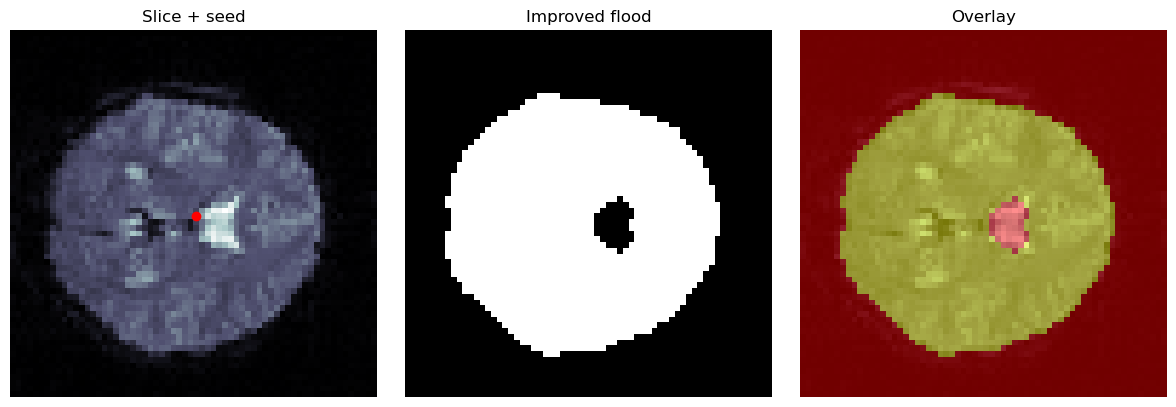

In [ ]:
# pick a seed well inside tissue (not on CSF/skull)
seed = (slice10.shape[0]//2, slice10.shape[1]//2)  # or click-derived
mask_flood = flood_brain_2d(slice10, seed,
                            sigma=1.0,
                            tol_mode="local", tol_val=1.5,
                            connectivity=2)

# visualize
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(slice10, cmap="bone"); ax[0].plot(seed[1], seed[0], 'ro'); ax[0].set_title("Slice + seed"); ax[0].axis("off")
ax[1].imshow(mask_flood, cmap="gray"); ax[1].set_title("Improved flood"); ax[1].axis("off")
ax[2].imshow(slice10, cmap="bone"); ax[2].imshow(mask_flood, alpha=0.45, cmap="autumn"); ax[2].set_title("Overlay"); ax[2].axis("off")
plt.tight_layout(); plt.show()




# 📌 4 Advanced Methods





## 4.1 Morphology as Post-Processing (the “free win”)

Even the best segmenter benefits from a light cleanup. Typical steps:

* **remove\_small\_objects**: delete tiny specks
* **remove\_small\_holes**: fill small gaps
* **opening / closing**: smooth boundaries
* **largest connected component**: keep only the biggest blob

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_opening, binary_closing

def clean_mask(mask, min_obj=200, min_hole=200, open_r=1, close_r=2):
    m = mask.astype(bool)
    m = remove_small_objects(m, min_obj)
    m = remove_small_holes(m, min_hole)
    if open_r:
        m = binary_opening(m, footprint=disk(open_r))
    if close_r:
        m = binary_closing(m, footprint=disk(close_r))
    return m.astype(np.uint8)

# Example: clean your best intensity/edge/region mask
# cleaned = clean_mask(mask_ws, min_obj=150, min_hole=150, open_r=1, close_r=2)

# Quick viz helper
def show_overlay(img, mask, title):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    ax.imshow(img, cmap="bone")
    ax.imshow(mask, alpha=0.45, cmap="autumn")
    ax.set_title(title); ax.axis("off")
    plt.show()

**Use in fMRI/MRI**: post-processing reduces false positives around skull/CSF and fixes small holes in the brain mask.

---

## 4.2 Clustering-Based Segmentation (K-means & GMM)

Clustering treats segmentation as **unsupervised classification** of voxels by their features (usually intensity). You can add simple spatial regularization afterward with morphology.

### A) K-means (fast, simple)

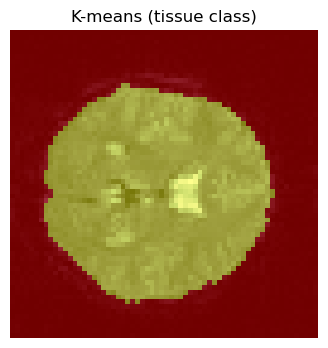

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Feature: intensity only (reshape to (N,1))
X = slice10.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0).fit(X)
labels_km = kmeans.labels_.reshape(slice10.shape)  # {0,1,2}

# Identify which label is background (lowest mean intensity)
means = [slice10[labels_km==i].mean() for i in range(3)]
order = np.argsort(means)   # low->high
bg, tissue, bright = order[0], order[1], order[2]

mask_km = (labels_km == tissue).astype(np.uint8)
mask_km = clean_mask(mask_km, min_obj=150, min_hole=150)

show_overlay(slice10, mask_km, "K-means (tissue class)")

### B) Gaussian Mixture Model (soft probabilities)

GMM models each class with a Gaussian; you get **posterior probabilities** and can pick the most probable class or threshold by probability.

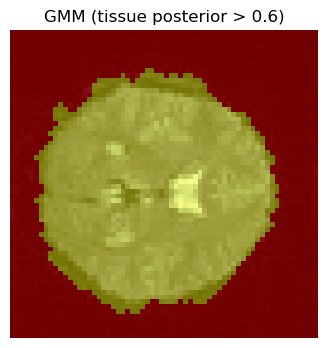

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=0)
gmm.fit(X)
proba = gmm.predict_proba(X)                 # (N,3)
label_map = gmm.predict(X).reshape(slice10.shape)

# Rank components by mean intensity to get tissue vs bg vs bright
means = gmm.means_.ravel()
rank = np.argsort(means)  # low->high
bg, tissue, bright = rank[0], rank[1], rank[2]

# Option 1: hard tissue class
mask_gmm = (label_map == tissue).astype(np.uint8)

# Option 2: soft threshold (more conservative)
p_tissue = proba[:, tissue].reshape(slice10.shape)
mask_gmm = (p_tissue > 0.6).astype(np.uint8)

mask_gmm = clean_mask(mask_gmm, min_obj=150, min_hole=150)
show_overlay(slice10, mask_gmm, "GMM (tissue posterior > 0.6)")

**Why it’s useful in neuro**

* K-means/GMM can separate **background / parenchyma / CSF/skull** without ground truth.
* GMM’s probabilities let you **tune strictness** (e.g., exclude high-uncertainty voxels).
* Add simple spatial priors by post-processing (opening/closing, largest component).

> Tip: You can enrich features with **spatial coordinates** to discourage scattered clusters:

In [ ]:
yy, xx = np.indices(slice10.shape)
X = np.c_[slice10.ravel(), 0.01*yy.ravel(), 0.01*xx.ravel()]  # small spatial weights


## 4.3 Random Walker (Graph-based, “probabilistic flood”)

The **random walker** is a powerful semi-supervised method: you provide sparse **markers** for foreground and background, and the algorithm computes the **probability** that a random walker from each unlabeled pixel first hits a FG or BG marker. It’s robust to noise and respects edges.

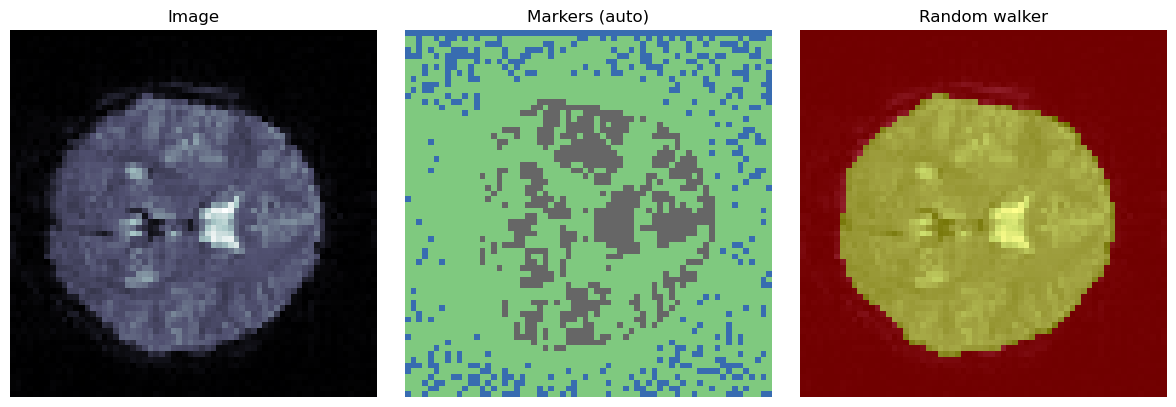

In [ ]:
import numpy as np
from skimage.segmentation import random_walker
from skimage.filters import sobel
import matplotlib.pyplot as plt

img = slice10.astype(float)

# Build markers automatically (you can also draw sparse seeds manually)
lo, hi = np.percentile(img, 10), np.percentile(img, 85)
markers = np.zeros_like(img, dtype=np.int32)
markers[img <= lo] = 1   # background seeds
markers[img >= hi] = 2   # foreground seeds

# A small amount of pre-smoothing helps
from skimage.filters import gaussian
img_s = gaussian(img, sigma=1, preserve_range=True)

# Run random walker (beta controls edge preference; ↑beta -> respect edges more)
labels_rw = random_walker(img_s, markers, beta=90, mode="bf")  # or mode="cg" for faster

mask_rw = (labels_rw == 2).astype(np.uint8)
mask_rw = clean_mask(mask_rw, min_obj=150, min_hole=150)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img, cmap="bone"); ax[0].set_title("Image"); ax[0].axis("off")
ax[1].imshow(markers, cmap="Accent"); ax[1].set_title("Markers (auto)"); ax[1].axis("off")
ax[2].imshow(img, cmap="bone"); ax[2].imshow(mask_rw, alpha=0.45, cmap="autumn"); ax[2].set_title("Random walker"); ax[2].axis("off")
plt.tight_layout(); plt.show()

**Why it’s useful in neuro**

* Great for **interactive correction**: add a few seeds to fix leaks or fill misses.
* Unlike flood, it uses a **global energy** so it’s less sensitive to local noise and has a built-in edge prior.

---

## 4.4 Putting it together (Auto-stack)

Here’s a quick compare of the three advanced masks on your slice:

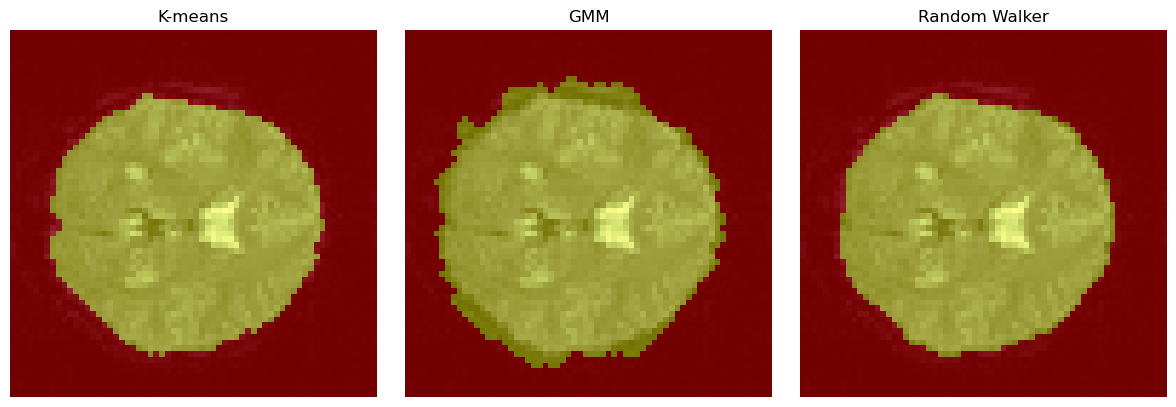

In [ ]:
def compare_three(img, m1, m2, m3, titles=("K-means","GMM","Random Walker")):
    figs, axes = plt.subplots(1,3, figsize=(12,4))
    for ax, M, t in zip(axes, (m1,m2,m3), titles):
        ax.imshow(img, cmap="bone"); ax.imshow(M, alpha=0.45, cmap="autumn")
        ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()

compare_three(slice10, mask_km, mask_gmm, mask_rw)

**Evaluation**

* With a true **brain mask** (GT), compute **Dice** as before.
* Without GT, compare against a **proxy** (e.g., Multi-Otsu tissue class) and inspect **disagreement maps**.

---

## 4.5 Deep Learning Segmentation (U-Net in a nutshell)

Modern neuro segmentation relies heavily on CNNs (e.g., **U-Net**). Key ideas:

* **Encoder–decoder** with **skip connections** to preserve details.
* Trained end-to-end on many labeled slices/volumes (T1, T2, fMRI derivatives).
* Losses: **Dice**, **Cross-Entropy**, or a combo.
* Heavy use of **augmentation** (flips, rotations, intensity jitter).
* Evaluation with Dice/HD95 across subjects.

Below is a **minimal PyTorch skeleton** to show structure. (It’s illustrative; you’d plug in your loader and train loop.)

In [ ]:
# Minimal U-Net-like skeleton (2D). For 3D, replace Conv2d with Conv3d, etc.
import torch, torch.nn as nn, torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=2, base=32):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.bott  = DoubleConv(base*2, base*4)
        self.up2   = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2  = DoubleConv(base*4, base*2)
        self.up1   = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1  = DoubleConv(base*2, base)
        self.out   = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        xb = self.bott(self.pool2(x2))
        x  = self.up2(xb)
        x  = self.dec2(torch.cat([x2, x], dim=1))
        x  = self.up1(x)
        x  = self.dec1(torch.cat([x1, x], dim=1))
        return self.out(x)  # logits

# Example forward (random tensor of one slice)
# model = UNet(in_ch=1, out_ch=2)
# logits = model(torch.randn(1,1,256,256))
# probs  = torch.softmax(logits, dim=1)
# pred   = probs.argmax(dim=1)   # [N,H,W] labels



**Training outline**

1. Normalize inputs; crop/resize consistently.
2. Batch your (image, mask) pairs (or patches).
3. Loss = Dice + Cross-Entropy; optimizer = Adam.
4. Validate with Dice; early stop; save best checkpoint.
5. Inference on full volumes (2.5D/3D; sliding windows if large).

**When to use CNNs in fMRI**

* Building robust **brain masks** across scanners/sequences.
* Segmenting **lesions**, **tumors**, or **functional ROIs** when annotations exist.
* Requires **data** and **labels**; otherwise stick with the classical stack above.

---

## Which advanced method should I try first?

* Need strong results with minimal setup? → **K-means or GMM + morphology**.
* Want interactive, edge-respecting correction? → **Random Walker**.
* Need state-of-the-art accuracy and you have labels & compute? → **U-Net** (deep learning).




---

# **TASKS**

# 🟢 Task 1 — Intensity thresholding (brain vs. air)

**Goal**
Build a baseline **brain-vs-background** mask from a single anatomical slice; compare **Mean** vs **Otsu** thresholds.

**Dataset**

SPM single-subject T1 (from the SPM auditory sample) : `spm = datasets.fetch_spm_auditory()  →  anat_path = spm.anat  →  image.load_img(anat_path)` → pick a **mid-axial** slice.

**Do**

1. Plot the slice **histogram** and mark the **mean** and **Otsu** thresholds.
2. Create two binary masks: `mask_mean`, `mask_otsu`.
3. Overlay each mask on the slice for visual inspection.
4. Report quick sanity metrics: background intensity under each mask’s complement (lower is better) and count of tiny components (< 50 px).

**Deliverables**

* Histogram with two threshold lines.
* Two overlays (Mean vs Otsu).
* A 3–5 line table of metrics.

**Question (3–4 sentences)**
Which threshold (Mean vs Otsu) better removes **air** without eating into cortex, and how do your metrics support that conclusion?

[wrapper] Dataset found in C:\Users\Saye\nilearn_data\spm_auditory
name   area   inside_mean   outside_mean   tiny_components
mean   24501   0.3868        0.0141          12
otsu   23021   0.4001        0.0199          18
Dice(mean, otsu) = 0.969


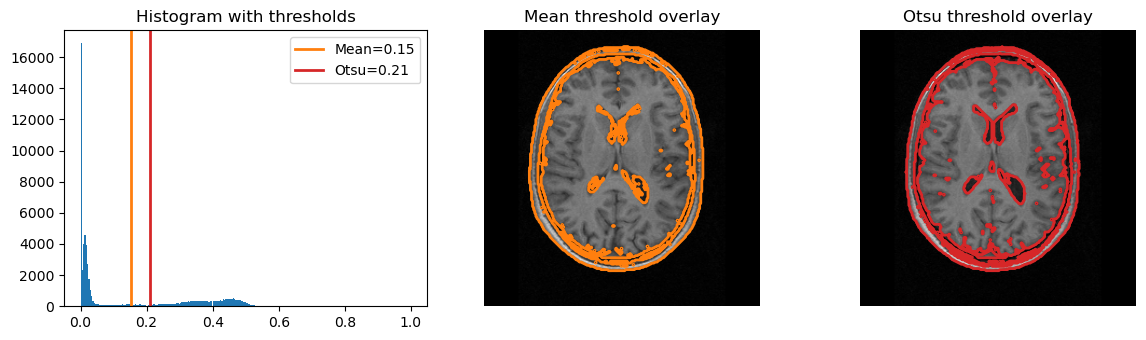

In [8]:
# Task 1 — Mean vs Otsu (clean metrics + clearer plots)
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets ,image
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

# 1) Load mid-axial slice and normalize to [0,1]
spm =  datasets.fetch_spm_auditory()
anat_path = spm.anat
t1 = image.load_img(anat_path)
vol = t1.get_fdata()
z = vol.shape[2] // 2
sl = vol[:, :, z]
sl = (sl - sl.min()) / (np.ptp(sl) + 1e-8)

# 2) Thresholds
t_mean = float(sl.mean())
t_otsu = float(threshold_otsu(sl))

# 3) Masks
mask_mean = sl > t_mean
mask_otsu = sl > t_otsu

# 4) Metrics helpers
def tiny_components_count(mask, min_area=50):
    lab = label(mask, connectivity=2)
    return int(sum(r.area < min_area for r in regionprops(lab)))

def describe(mask, name):
    area    = int(mask.sum())
    in_mean = float(sl[mask].mean()) if area > 0 else float("nan")
    out_mean= float(sl[~mask].mean())
    tiny    = tiny_components_count(mask)
    return name, area, in_mean, out_mean, tiny

def dice(a, b):
    a = a.astype(bool); b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    return float(2.0 * inter / (a.sum() + b.sum() + 1e-8))

# 5) Print a compact, readable table
rows = [describe(mask_mean, "mean"), describe(mask_otsu, "otsu")]
print("name   area   inside_mean   outside_mean   tiny_components")
for r in rows:
    print(f"{r[0]:<6} {r[1]:5d}   {r[2]:.4f}        {r[3]:.4f}          {r[4]}")

print(f"Dice(mean, otsu) = {dice(mask_mean, mask_otsu):.3f}")

# 6) Plots: histogram + overlays with thicker contours
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

ax[0].hist(sl.ravel(), bins=256)
ax[0].axvline(t_mean, color='C1', linewidth=2, label=f"Mean={t_mean:.2f}")
ax[0].axvline(t_otsu, color='C3', linewidth=2, label=f"Otsu={t_otsu:.2f}")
ax[0].set_title("Histogram with thresholds"); ax[0].legend()

ax[1].imshow(sl.T, cmap='gray', origin='lower')
ax[1].contour(mask_mean.T, [0.5], colors='C1', linewidths=2.0)
ax[1].set_title("Mean threshold overlay"); ax[1].axis('off')

ax[2].imshow(sl.T, cmap='gray', origin='lower')
ax[2].contour(mask_otsu.T, [0.5], colors='C3', linewidths=2.0)
ax[2].set_title("Otsu threshold overlay"); ax[2].axis('off')

plt.tight_layout(); plt.show()


# 🟡 Task 2 — Multi-Otsu (3 classes: bg / tissue / bright)

**Goal**
Segment a slice into **three** classes to separate **background**, **brain tissue**, and **bright CSF/skull**.

**Dataset**
Same SPM single-subject T1  : `spm = datasets.fetch_spm_auditory()  →  anat_path = spm.anat  →  image.load_img(anat_path)` → pick a **mid-axial** slice.

**Do**

1. Run **Multi-Otsu** with `classes=3` to obtain two thresholds.
2. Convert to a **label map** {0: bg, 1: tissue, 2: bright}.
3. Visualize the label map and an **overlay** on the slice.
4. Compute and report the **mean intensity** of each class and the **area** (pixel count).

**Deliverables**

* Label map figure and overlay.
* One small table: class → (area, mean intensity).

**Question (2–3 sentences)**
Why does Multi-Otsu reduce CSF/ventricle leakage compared to single-threshold Otsu?

[wrapper] Dataset found in C:\Users\Saye\nilearn_data\spm_auditory
class  area  mean_intensity
(0, 41163, 3.6488351189174746)
(1, 10932, 74.8919685327479)
(2, 13441, 115.70151030429284)


C:\Users\Saye\AppData\Local\Temp\ipykernel_7524\568605709.py:35: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour((labels==1).T, [0.5], colors='C2', linewidths=1.2, label='tissue')
C:\Users\Saye\AppData\Local\Temp\ipykernel_7524\568605709.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour((labels==2).T, [0.5], colors='C3', linewidths=1.0, label='bright')


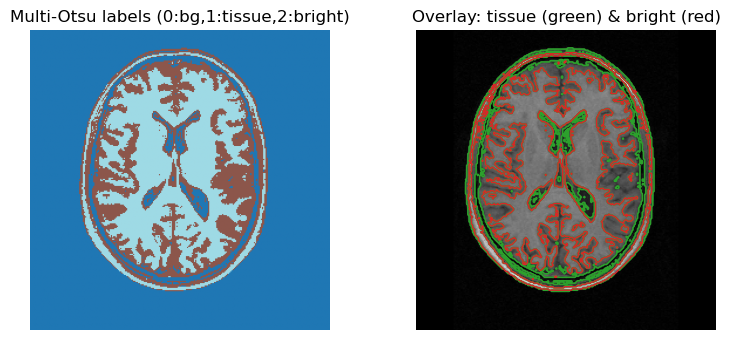

In [9]:
# Solution: Task 2 (Multi-Otsu 3-class segmentation)
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets,image
from skimage.filters import threshold_multiotsu

# 1) Load slice
spm =  datasets.fetch_spm_auditory()
anat_path = spm.anat
t1 = image.load_img(anat_path)
vol = t1.get_fdata()
z = vol.shape[2] // 2
sl = vol[:, :, z]

# 2) Multi-Otsu thresholds for 3 classes
th = threshold_multiotsu(sl, classes=3)  # two thresholds
labels = np.digitize(sl, bins=th)        # 0:bg, 1:tissue, 2:bright

# 3) Class stats
table = []
for c in (0, 1, 2):
    sel = labels == c
    area = int(sel.sum())
    mval = float(sl[sel].mean()) if area > 0 else float('nan')
    table.append((c, area, mval))
print("class  area  mean_intensity")
for row in table: print(row)

# 4) Plots: label map + overlay
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
ax[0].imshow(labels.T, origin='lower', cmap='tab20')
ax[0].set_title("Multi-Otsu labels (0:bg,1:tissue,2:bright)"); ax[0].axis('off')

ax[1].imshow(sl.T, cmap='gray', origin='lower')
ax[1].contour((labels==1).T, [0.5], colors='C2', linewidths=1.2, label='tissue')
ax[1].contour((labels==2).T, [0.5], colors='C3', linewidths=1.0, label='bright')
ax[1].set_title("Overlay: tissue (green) & bright (red)"); ax[1].axis('off')
plt.tight_layout(); plt.show()


# 🔵 Task 3 — Edge-based segmentation (Canny + morphology)

**Goal**
Create a brain mask from **edges**, then compare with an intensity-based mask using a quantitative similarity score.

**Dataset**

Same SPM single-subject T1  : `spm = datasets.fetch_spm_auditory()  →  anat_path = spm.anat  →  image.load_img(anat_path)` → pick a **mid-axial** slice.

**Do**

1. Run **Canny** (e.g., `sigma=2`) → **fill holes** → (optional) light **erosion** → **remove small objects** → `mask_edge`.
2. Build an **intensity proxy**: Otsu threshold on the slice → `mask_otsu`.
3. Compute **Dice(mask_edge, mask_otsu)** and a **disagreement map** (FP=red, FN=blue).
4. Show a 3-panel figure: Original, Otsu overlay, Edge-based overlay; plus a disagreement map.

**Deliverables**

* Two comparison figures (overlays + disagreement).
* The Dice score and FP/FN counts.

**Question (3–5 sentences)**
Which method better delineates the **brain boundary** and why? Use your Dice/FP/FN results and discuss the effect of **sigma** on missed or spurious edges.

[wrapper] Dataset found in C:\Users\Saye\nilearn_data\spm_auditory
Dice(edge, otsu) = 0.907 | FP=4695  FN=0


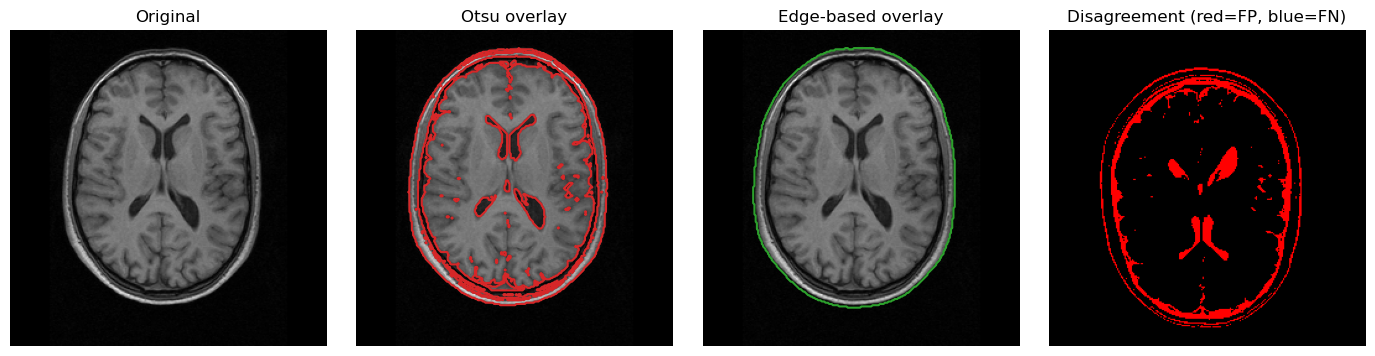

In [10]:
# Task 3 — Canny + morphology vs Otsu (fixed: use footprint=)
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image
from skimage import feature, filters
from skimage.morphology import disk, binary_dilation, binary_erosion, remove_small_objects
from scipy.ndimage import binary_fill_holes

# 1) Load slice
spm =  datasets.fetch_spm_auditory()
anat_path = spm.anat
t1 = image.load_img(anat_path)
sl = t1.get_fdata()[:, :, t1.shape[2] // 2]
sl_norm = (sl - sl.min()) / (np.ptp(sl) + 1e-8)

# 2) Edge-based mask
edges = feature.canny(sl_norm, sigma=2)                    # bool
edges_d = binary_dilation(edges, footprint=disk(2))        # <-- fixed
mask_edge = binary_fill_holes(edges_d)
mask_edge = remove_small_objects(mask_edge, 100)
mask_edge = binary_erosion(mask_edge, footprint=disk(1))   # <-- fixed

# 3) Intensity-based mask (Otsu)
t_otsu = filters.threshold_otsu(sl)
mask_otsu = sl > t_otsu

# 4) Dice & disagreement
def dice(a, b):
    a = a.astype(bool); b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    return 2.0 * inter / (a.sum() + b.sum() + 1e-8)

D = dice(mask_edge, mask_otsu)
fp = np.logical_and(mask_edge, ~mask_otsu)
fn = np.logical_and(~mask_edge, mask_otsu)
print(f"Dice(edge, otsu) = {D:.3f} | FP={int(fp.sum())}  FN={int(fn.sum())}")

# 5) Plots
fig, ax = plt.subplots(1, 4, figsize=(14, 3.5))
ax[0].imshow(sl.T, cmap='gray', origin='lower'); ax[0].set_title('Original'); ax[0].axis('off')
ax[1].imshow(sl.T, cmap='gray', origin='lower'); ax[1].contour(mask_otsu.T, [0.5], colors='C3'); ax[1].set_title('Otsu overlay'); ax[1].axis('off')
ax[2].imshow(sl.T, cmap='gray', origin='lower'); ax[2].contour(mask_edge.T, [0.5], colors='C2'); ax[2].set_title('Edge-based overlay'); ax[2].axis('off')

rgb = np.zeros((*sl.T.shape, 3), float)
rgb[..., 0] = fp.T.astype(float)   # red = FP
rgb[..., 2] = fn.T.astype(float)   # blue = FN
ax[3].imshow(rgb); ax[3].set_title('Disagreement (red=FP, blue=FN)'); ax[3].axis('off')
plt.tight_layout(); plt.show()



# 🔴 Task 4 — Region-based (marker-driven watershed)

**Goal**
Use **markers** and **gradients** to obtain a boundary-aware mask, then justify parameter choices with simple metrics.

**Dataset**

Same SPM single-subject T1  : `spm = datasets.fetch_spm_auditory()  →  anat_path = spm.anat  →  image.load_img(anat_path)` → pick a **mid-axial** slice.

**Do**

1. Build **foreground/background markers** automatically (e.g., Multi-Otsu mid-class = FG, darkest class = BG) or choose a few **seeds** manually.
2. Compute a **gradient image** (e.g., Sobel magnitude).
3. Run **watershed** on the gradient with your markers → `mask_ws`.
4. (Optional) Light **post-processing**: remove small objects/holes, small opening/closing.
5. Compare `mask_ws` to `mask_otsu` from Task 3 with **Dice** and a boundary overlay.

**Deliverables**

* Gradient, markers, and watershed overlay figures.
* A short table: area, #components for `mask_ws` vs `mask_otsu`, plus Dice.

**Question (3–5 sentences)**
How did markers and gradient guidance reduce leakage into skull/CSF while preserving cortex, compared with pure thresholds? Cite your metrics (area/components/Dice).



[wrapper] Dataset found in C:\Users\Saye\nilearn_data\spm_auditory
WS: area=25920 comps=1 | Otsu: area=23021 comps=20 | Dice=0.939


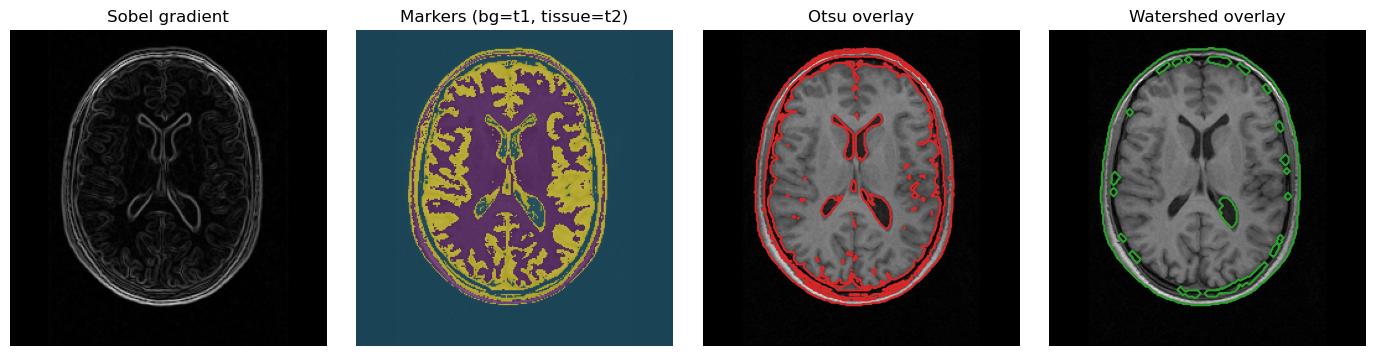

In [11]:
# Solution: Task 4 (Watershed with markers + metrics)
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image
from skimage.filters import threshold_otsu, threshold_multiotsu, sobel
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_opening, binary_closing
from skimage.measure import label

# 1) Load slice
spm =  datasets.fetch_spm_auditory()
anat_path = spm.anat
t1 = image.load_img(anat_path)
sl = t1.get_fdata()[:, :, t1.shape[2] // 2]
sl_norm = (sl - sl.min()) / (np.ptp(sl) + 1e-8)

# 2) Markers from Multi-Otsu (3 classes)
th = threshold_multiotsu(sl, classes=3)
lbl = np.digitize(sl, bins=th)     # 0:bg (dark), 1:tissue (mid), 2:bright (skull/CSF etc.)

markers = np.zeros_like(sl, dtype=int)
markers[lbl == 0] = 1   # background marker
markers[lbl == 1] = 2   # brain-tissue marker
# (Optionally) treat very bright as another label → markers[lbl == 2] = 3

# 3) Gradient image & watershed
grad = sobel(sl_norm)
ws = watershed(grad, markers)

# 4) Extract brain region (label==2) and light post-process
mask_ws = (ws == 2)
mask_ws = remove_small_holes(mask_ws, area_threshold=200)
mask_ws = remove_small_objects(mask_ws, 100)
mask_ws = binary_opening(mask_ws, disk(1))
mask_ws = binary_closing(mask_ws, disk(2))

# 5) Reference intensity mask (Otsu) for comparison
t_otsu = threshold_otsu(sl)
mask_otsu = sl > t_otsu

# 6) Metrics
def dice(a, b):
    a = a.astype(bool); b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    return 2.0 * inter / (a.sum() + b.sum() + 1e-8)

def area_cc(mask):
    A = int(mask.sum())
    C = int(label(mask, connectivity=2).max())
    return A, C

A_ws, C_ws = area_cc(mask_ws)
A_ot, C_ot = area_cc(mask_otsu)
D = dice(mask_ws, mask_otsu)
print(f"WS: area={A_ws} comps={C_ws} | Otsu: area={A_ot} comps={C_ot} | Dice={D:.3f}")

# 7) Plots: gradient, markers, overlays
fig, ax = plt.subplots(1, 4, figsize=(14, 3.5))
ax[0].imshow(grad.T, cmap='gray', origin='lower'); ax[0].set_title('Sobel gradient'); ax[0].axis('off')

mk_show = np.zeros_like(sl)
mk_show[markers==1] = 0.3
mk_show[markers==2] = 0.8
ax[1].imshow(sl.T, cmap='gray', origin='lower'); ax[1].imshow(mk_show.T, cmap='viridis', alpha=0.6, origin='lower')
ax[1].set_title('Markers (bg=t1, tissue=t2)'); ax[1].axis('off')

ax[2].imshow(sl.T, cmap='gray', origin='lower'); ax[2].contour(mask_otsu.T, [0.5], colors='C3')
ax[2].set_title('Otsu overlay'); ax[2].axis('off')

ax[3].imshow(sl.T, cmap='gray', origin='lower'); ax[3].contour(mask_ws.T, [0.5], colors='C2')
ax[3].set_title('Watershed overlay'); ax[3].axis('off')

plt.tight_layout(); plt.show()
